# Capstone Project - Analysis of outbound flights from Anchorage airport for 2023 & 2024 & ML predictions of flight delays

## Part 1 - Analytics on Raw Data from BTS

We will begin using raw data from the [Bureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr) for Alaska region. A total of 24 files were downloaded on a monthly basis to capture all the data for 2023 & 2024.

In [1]:
# Install airpors data - will be required in part 2
# pip install requests pandas airportsdata

In [2]:
# Install meteostat - will be required in part 2
# pip install meteostat

In [3]:
# Libraries
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from airportsdata import load
import os
from meteostat import Hourly, Stations
from datetime import timedelta
from tqdm import tqdm
import ssl
import time
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tabulate import tabulate


import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_palette("viridis")

plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "grid.color": "lightgray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
})


In [4]:
# Change certificate bundle due to issues with API's - this will be required in part 2
os.environ["REQUESTS_CA_BUNDLE"] = r"C:\Users\RC06986\AnacondaZ\Lib\site-packages\certifi\cacert.pem"

## Preparation of data & basic cleanup

In [5]:
# Load data
all_files = glob.glob("Raw_Data/*.csv")
if not all_files:
    raise FileNotFoundError("No CSV files found")
df = pd.concat((pd.read_csv(f) for f in all_files))

In [6]:
# Basic checks have been done on the data to make sure everything is generally ok; nothing has been missed
df[['YEAR', 'MONTH']].drop_duplicates().sort_values(['YEAR', 'MONTH'])

YEAR  MONTH
0  2023      1
0  2023      2
0  2023      3
0  2023      4
0  2023      5
0  2023      6
0  2023      7
0  2023      8
0  2023      9
0  2023     10
0  2023     11
0  2023     12
0  2024      1
0  2024      2
0  2024      3
0  2024      4
0  2024      5
0  2024      6
0  2024      7
0  2024      8
0  2024      9
0  2024     10
0  2024     11
0  2024     12

**We will also do some data cleanup in this section:**
* We will filter to only the columns that are of interest to us for this Capstone project
* Only Ancorage origin airport will be looked at
* The actual carrier descriptions will be shown
* Cancellation code descriptions will be shown
* Delays over 60 minutes will be looked at - a respective column will be added to the data

In [7]:
# Columns that will be kept for analysis
columns_to_keep =  [
    "YEAR",
    "QUARTER",
    "MONTH",
    "FL_DATE",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",
    "OP_UNIQUE_CARRIER",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",
    "ORIGIN",
    "DEST",
    "CRS_DEP_TIME",
    "CRS_ARR_TIME",
    "CANCELLED",
    "CANCELLATION_CODE",
    "DIVERTED",
    "AIR_TIME",
    "DISTANCE",
    "CARRIER_DELAY",
    "WEATHER_DELAY",
    "NAS_DELAY",
    "SECURITY_DELAY",
    "LATE_AIRCRAFT_DELAY" ]

# Delay threshold of 60 mins
delay_threshold = 60

# Filtering & Replacing
df1 = df.copy()
df1 = df1[columns_to_keep]
df1 = df1[df1['ORIGIN'] == 'ANC']
df1['OP_UNIQUE_CARRIER'] = df1['OP_UNIQUE_CARRIER'].replace(['AS', 'DL', 'UA', 'AA'], ['Alaska Airlines', 'Delta', 'United', 'American Airlines'])
df1['CANCELLATION_CODE'] = df1['CANCELLATION_CODE'].replace(['A', 'B', 'C'], ['Carrier', 'Weather', 'National Air System'])

# Tidy up delay columns
df1["CARRIER_DELAY"] = df1["CARRIER_DELAY"].fillna(0)
df1["WEATHER_DELAY"] = df1["WEATHER_DELAY"].fillna(0)
df1["NAS_DELAY"] = df1["NAS_DELAY"].fillna(0)
df1["SECURITY_DELAY"] = df1["SECURITY_DELAY"].fillna(0)
df1["LATE_AIRCRAFT_DELAY"] = df1["LATE_AIRCRAFT_DELAY"].fillna(0)

# Create totals & classification of the delay
df1['TOTAL_DELAY'] = df1["CARRIER_DELAY"] + df1["WEATHER_DELAY"] + df1["NAS_DELAY"] + df1["SECURITY_DELAY"] + df1["LATE_AIRCRAFT_DELAY"]
df1['CRITICAL_DELAY'] = np.where(
    (df1['TOTAL_DELAY'] >= delay_threshold) | 
    (df1['CANCELLED'] == 1) | 
    (df1['DIVERTED'] == 1),
    1,  # if true
    0   # else
)

df1['FL_DATE'] = pd.to_datetime(df1['FL_DATE'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

In [8]:
#df1['OP_UNIQUE_CARRIER'].value_counts()
#df1['CANCELLATION_CODE'].value_counts()
#df1['CANCELLED'].value_counts()
#df1['DIVERTED'].value_counts()
# df1['CRITICAL_DELAY'].value_counts(normalize = True)

## Comparing Airlines

### Airline Performance Comparison

#### Prep Data

In [9]:
# Use total_flights index as master carrier list (guaranteed alignment)
total_flights = df1.groupby('OP_UNIQUE_CARRIER').size()
airlines = total_flights.index

# Critically delayed flights
total_flights_delayed = df1[df1['CRITICAL_DELAY'] == 1].groupby('OP_UNIQUE_CARRIER')['YEAR'].count()
total_flights_delayed = total_flights_delayed.reindex(airlines, fill_value=0)

# On-time flights
total_flights_on_time = df1[df1['TOTAL_DELAY'] == 0].groupby('OP_UNIQUE_CARRIER')['YEAR'].count()
total_flights_on_time = total_flights_on_time.reindex(airlines, fill_value=0)

# Average delays
avg_delays_non_crit = df1[df1['CRITICAL_DELAY'] != 1].groupby('OP_UNIQUE_CARRIER')['TOTAL_DELAY'].mean().reindex(airlines, fill_value=0)
avg_delays_crit = df1[df1['CRITICAL_DELAY'] == 1].groupby('OP_UNIQUE_CARRIER')['TOTAL_DELAY'].mean().reindex(airlines, fill_value=0)

# Critical delay fraction
critical_delay_fraction = df1.groupby('OP_UNIQUE_CARRIER')['CRITICAL_DELAY'].mean().reindex(airlines, fill_value=0) * 100

# Cancellations / Diversions
cancellations = df1[df1['CANCELLED'] == 1].groupby('OP_UNIQUE_CARRIER')['CANCELLED'].count().reindex(airlines, fill_value=0)
diversions = df1[df1['DIVERTED'] == 1].groupby('OP_UNIQUE_CARRIER')['DIVERTED'].count().reindex(airlines, fill_value=0)

# Normalize by total flights
cancellations_norm = cancellations / total_flights * 100
diversions_norm = diversions / total_flights * 100

In [10]:
total_flights

OP_UNIQUE_CARRIER
Alaska Airlines      28238
American Airlines      964
Delta                 4831
United                2360
dtype: int64

#### Plot Data

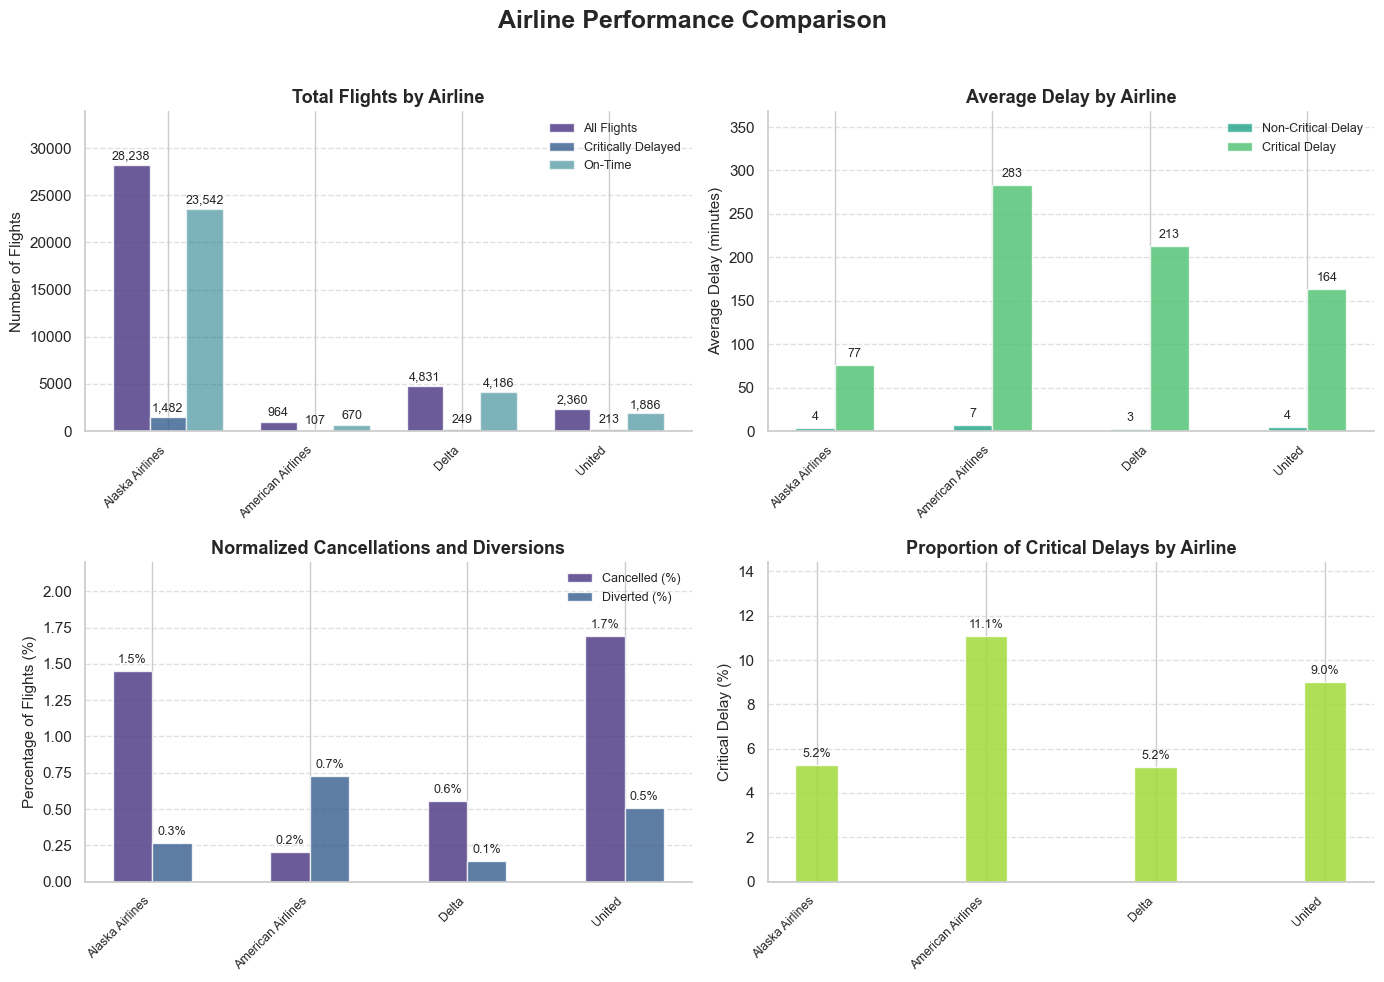

In [11]:
sns.set_theme(style="whitegrid")
palette = sns.color_palette("viridis", n_colors=6)  # unified viridis palette
x = np.arange(len(airlines))
width = 0.25

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
fig.suptitle("Airline Performance Comparison", fontsize=18, fontweight='bold', y=0.98)

# ---- Total Flights vs Delayed ----
ax = axes[0]
bars_all = ax.bar(x - width, total_flights, width, label='All Flights', color=palette[0], alpha=0.8)
bars_crit = ax.bar(x, total_flights_delayed, width, label='Critically Delayed', color=palette[1], alpha=0.8)
bars_on_time = ax.bar(x + width, total_flights_on_time, width, label='On-Time', color=palette[2], alpha=0.6)

max_total = max(total_flights.max(), total_flights_delayed.max(), total_flights_on_time.max())
for bars in [bars_all, bars_crit, bars_on_time]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + max_total*0.01, f'{int(h):,}', 
                ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Number of Flights', fontsize=11)
ax.set_title('Total Flights by Airline', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(airlines, rotation=45, ha='right', fontsize=9)
ax.legend(frameon=False, fontsize=9)
ax.set_ylim(0, max_total*1.2)

# ---- Average Delay ----
ax = axes[1]
bars_non_crit = ax.bar(x - width/2, avg_delays_non_crit, width, label='Non-Critical Delay', color=palette[3], alpha=0.8)
bars_crit_delay = ax.bar(x + width/2, avg_delays_crit, width, label='Critical Delay', color=palette[4], alpha=0.8)

max_delay = max(avg_delays_non_crit.max(), avg_delays_crit.max())
for bars in [bars_non_crit, bars_crit_delay]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + max_delay*0.02, f'{h:.0f}', 
                ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Average Delay (minutes)', fontsize=11)
ax.set_title('Average Delay by Airline', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(airlines, rotation=45, ha='right', fontsize=9)
ax.legend(frameon=False, fontsize=9)
ax.set_ylim(0, max_delay*1.3)

# ---- Normalized Cancellations & Diversions ----
ax = axes[2]
bars_cancel = ax.bar(x - width/2, cancellations_norm, width, label='Cancelled (%)', color=palette[0], alpha=0.8)
bars_divert = ax.bar(x + width/2, diversions_norm, width, label='Diverted (%)', color=palette[1], alpha=0.8)

max_norm = max(cancellations_norm.max(), diversions_norm.max())
for bars in [bars_cancel, bars_divert]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + max_norm*0.02, f'{h:.1f}%', 
                ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Percentage of Flights (%)', fontsize=11)
ax.set_title('Normalized Cancellations and Diversions', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(airlines, rotation=45, ha='right', fontsize=9)
ax.legend(frameon=False, fontsize=9)
ax.set_ylim(0, max_norm*1.3)

# ---- Critical Delay Fraction ----
ax = axes[3]
bars_crit_frac = ax.bar(x, critical_delay_fraction, width, color=palette[5], alpha=0.85)

for bar in bars_crit_frac:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + max(critical_delay_fraction)*0.02, f'{h:.1f}%', 
            ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Critical Delay (%)', fontsize=11)
ax.set_title('Proportion of Critical Delays by Airline', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(airlines, rotation=45, ha='right', fontsize=9)
ax.set_ylim(0, max(critical_delay_fraction)*1.3)

# ---- Global Styling ----
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', labelsize=9)
    ax.set_axisbelow(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Flight Delays Breakdown

#### Prep Data

In [12]:
avg_critical_delay_carrier = df1[df1['CRITICAL_DELAY'] == 1].groupby('OP_UNIQUE_CARRIER')["CARRIER_DELAY"].mean().reindex(airlines, fill_value=0)
avg_critical_delay_weather = df1[df1['CRITICAL_DELAY'] == 1].groupby('OP_UNIQUE_CARRIER')["WEATHER_DELAY"].mean().reindex(airlines, fill_value=0)
avg_critical_delay_nas = df1[df1['CRITICAL_DELAY'] == 1].groupby('OP_UNIQUE_CARRIER')["NAS_DELAY"].mean().reindex(airlines, fill_value=0)
avg_critical_delay_security = df1[df1['CRITICAL_DELAY'] == 1].groupby('OP_UNIQUE_CARRIER')["SECURITY_DELAY"].mean().reindex(airlines, fill_value=0)
avg_critical_delay_aircraft = df1[df1['CRITICAL_DELAY'] == 1].groupby('OP_UNIQUE_CARRIER')["LATE_AIRCRAFT_DELAY"].mean().reindex(airlines, fill_value=0)

critical_delays = df1[df1['CRITICAL_DELAY'] != 0]

delay_data = {
    'Carrier': critical_delays[['OP_UNIQUE_CARRIER', 'CARRIER_DELAY']],
    'Weather': critical_delays[['OP_UNIQUE_CARRIER', 'WEATHER_DELAY']],
    'NAS': critical_delays[['OP_UNIQUE_CARRIER', 'NAS_DELAY']],
    'Security': critical_delays[['OP_UNIQUE_CARRIER', 'SECURITY_DELAY']],
    'Late Aircraft': critical_delays[['OP_UNIQUE_CARRIER', 'LATE_AIRCRAFT_DELAY']]
}

#### Plot Data

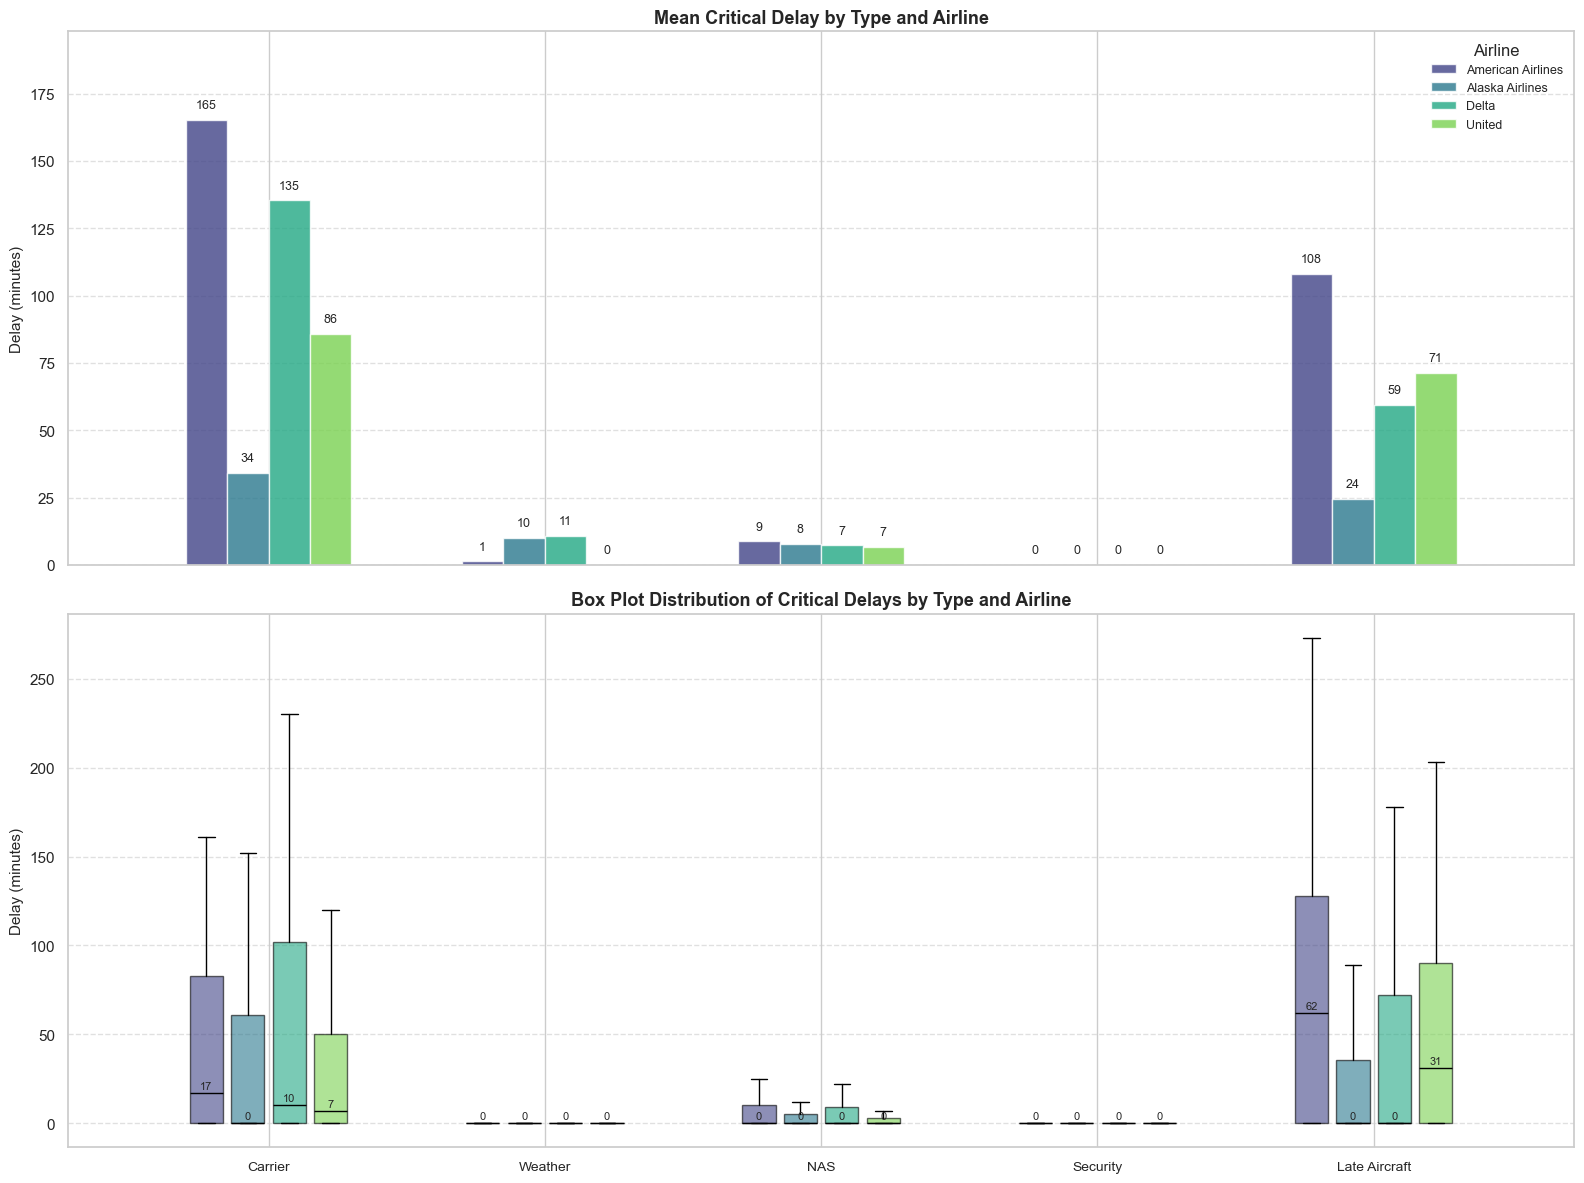

In [13]:
sns.set_theme(style="whitegrid")

delay_types = ['Carrier', 'Weather', 'NAS', 'Security', 'Late Aircraft']
delay_cols = ["CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"]
airlines = df1['OP_UNIQUE_CARRIER'].unique().tolist()

x = np.arange(len(delay_types))
width = 0.15  # spacing for multiple airlines
colors = sns.color_palette("viridis", n_colors=len(airlines))  # unified viridis palette

# -------------------------
# BAR CHART DATA: mean delays for critical flights
# -------------------------
avg_delays = []
for col in delay_cols:
    avg = (
        df1[df1['CRITICAL_DELAY'] == 1]
        .groupby('OP_UNIQUE_CARRIER')[col]
        .mean()
        .reindex(airlines, fill_value=0)
    )
    avg_delays.append(avg.values)

data_bar = np.array(avg_delays).T  # shape: (num_airlines, num_delay_types)

# -------------------------
# BOXPLOT DATA: all critical delays
# -------------------------
critical_delays = df1[df1['CRITICAL_DELAY'] != 0]

data_box = []
for col in delay_cols:
    airline_data = [
        critical_delays[critical_delays['OP_UNIQUE_CARRIER'] == airline][col].dropna().values
        for airline in airlines
    ]
    data_box.append(airline_data)

# -------------------------
# CREATE FIGURE
# -------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# -------------------------
# BAR CHART: mean critical delays
# -------------------------
for i, airline in enumerate(airlines):
    ax1.bar(
        x + (i - (len(airlines)-1)/2) * width,
        data_bar[i],
        width,
        label=airline,
        color=colors[i],
        alpha=0.8
    )

# Add numeric labels on bars
for i, airline in enumerate(airlines):
    for j, value in enumerate(data_bar[i]):
        ax1.text(
            x[j] + (i - (len(airlines)-1)/2) * width,
            value + max(data_bar.flatten()) * 0.02,
            f'{round(value)}',
            ha='center',
            va='bottom',
            fontsize=9
        )

ax1.set_ylabel('Delay (minutes)', fontsize=11)
ax1.set_title('Mean Critical Delay by Type and Airline', fontsize=13, fontweight='bold')
ax1.set_ylim(0, max(data_bar.flatten()) * 1.2)
ax1.legend(title='Airline', frameon=False, fontsize=9)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# -------------------------
# BOXPLOTS: distributions of critical delays
# -------------------------
for j, delay_type_data in enumerate(data_box):
    n_airlines = len(delay_type_data)
    offsets = np.linspace(-(n_airlines-1)/2, (n_airlines-1)/2, n_airlines) * width
    
    for i, airline_data in enumerate(delay_type_data):
        if len(airline_data) == 0:
            continue
        
        pos = j + offsets[i]
        ax2.boxplot(
            airline_data,
            positions=[pos],
            widths=width*0.8,
            patch_artist=True,
            boxprops=dict(facecolor=colors[i], alpha=0.6),
            medianprops=dict(color='black'),
            showfliers=False
        )
        
        # Add median label
        median_val = np.median(airline_data)
        ax2.text(
            pos,
            median_val + max([np.median(d) if len(d) > 0 else 0 for dt in data_box for d in dt]) * 0.02,
            f'{median_val:.0f}',
            ha='center',
            va='bottom',
            fontsize=8
        )

ax2.set_xticks(x)
ax2.set_xticklabels(delay_types, fontsize=10)
ax2.set_ylabel('Delay (minutes)', fontsize=11)
ax2.set_title('Box Plot Distribution of Critical Delays by Type and Airline', fontsize=13, fontweight='bold')
ax2.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


## Changes over time

### Performance

#### Prep Data

In [14]:
df1['FL_DATE'] = pd.to_datetime(df1['FL_DATE'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
daily_flights = df1.groupby('FL_DATE').size().reset_index(name='TOTAL_FLIGHTS')
critical_delays = df1[df1['CRITICAL_DELAY'] != 0].copy()
daily_delays = critical_delays.groupby('FL_DATE').size().reset_index(name='TOTAL_DELAY')
daily_counts = pd.merge(daily_flights, daily_delays, on='FL_DATE', how='left').fillna(0)
daily_counts['DELAY_RATIO'] = daily_counts['TOTAL_DELAY'] / daily_counts['TOTAL_FLIGHTS']

# if 'daily_counts' not in locals():
#     daily_counts = (
#         df1.groupby('FL_DATE', as_index=False)
#         .agg(
#             TOTAL_FLIGHTS=('FL_DATE', 'count'),
#             TOTAL_DELAY=('CRITICAL_DELAY', 'sum'),
#         )
#     )
#     daily_counts['DELAY_RATIO'] = daily_counts['TOTAL_DELAY'] / daily_counts['TOTAL_FLIGHTS']

try:
    daily_counts
except NameError:
    daily_counts = (
        df1.groupby('FL_DATE', as_index=False)
        .agg(
            TOTAL_FLIGHTS=('FL_DATE', 'count'),
            TOTAL_DELAY=('CRITICAL_DELAY', 'sum'),
        )
    )
    daily_counts['DELAY_RATIO'] = daily_counts['TOTAL_DELAY'] / daily_counts['TOTAL_FLIGHTS']


sns.set_theme(style="whitegrid")

#### Looking at examples

In [15]:
daily_counts.sort_values('DELAY_RATIO', ascending=False).head()

FL_DATE  TOTAL_FLIGHTS  TOTAL_DELAY  DELAY_RATIO
103 2023-04-14             45         26.0     0.577778
393 2024-01-29             37         21.0     0.567568
312 2023-11-09             41         21.0     0.512195
102 2023-04-13             43         19.0     0.441860
667 2024-10-29             40         15.0     0.375000

**Searching for new articles for the top 5 days with highest delays ratio's -**
* 2023-04-13 - *Ash from Russian volcano cancels Alaska flights*
* 2023-04-14 - *Russia volcano disrupts Alaska flights for third day in a row*
* 2023-11-09 - *Southcentral Alaska buried in more than a foot of snow from winter storm*
* 2024-01-29 - *Alaska governor’s annual speech to lawmakers delayed as high winds disrupt flights*
* 2024-10-29 - *Season’s first big snow fouls roads and shifts Anchorage schools to remote learning*

#### Plot Data

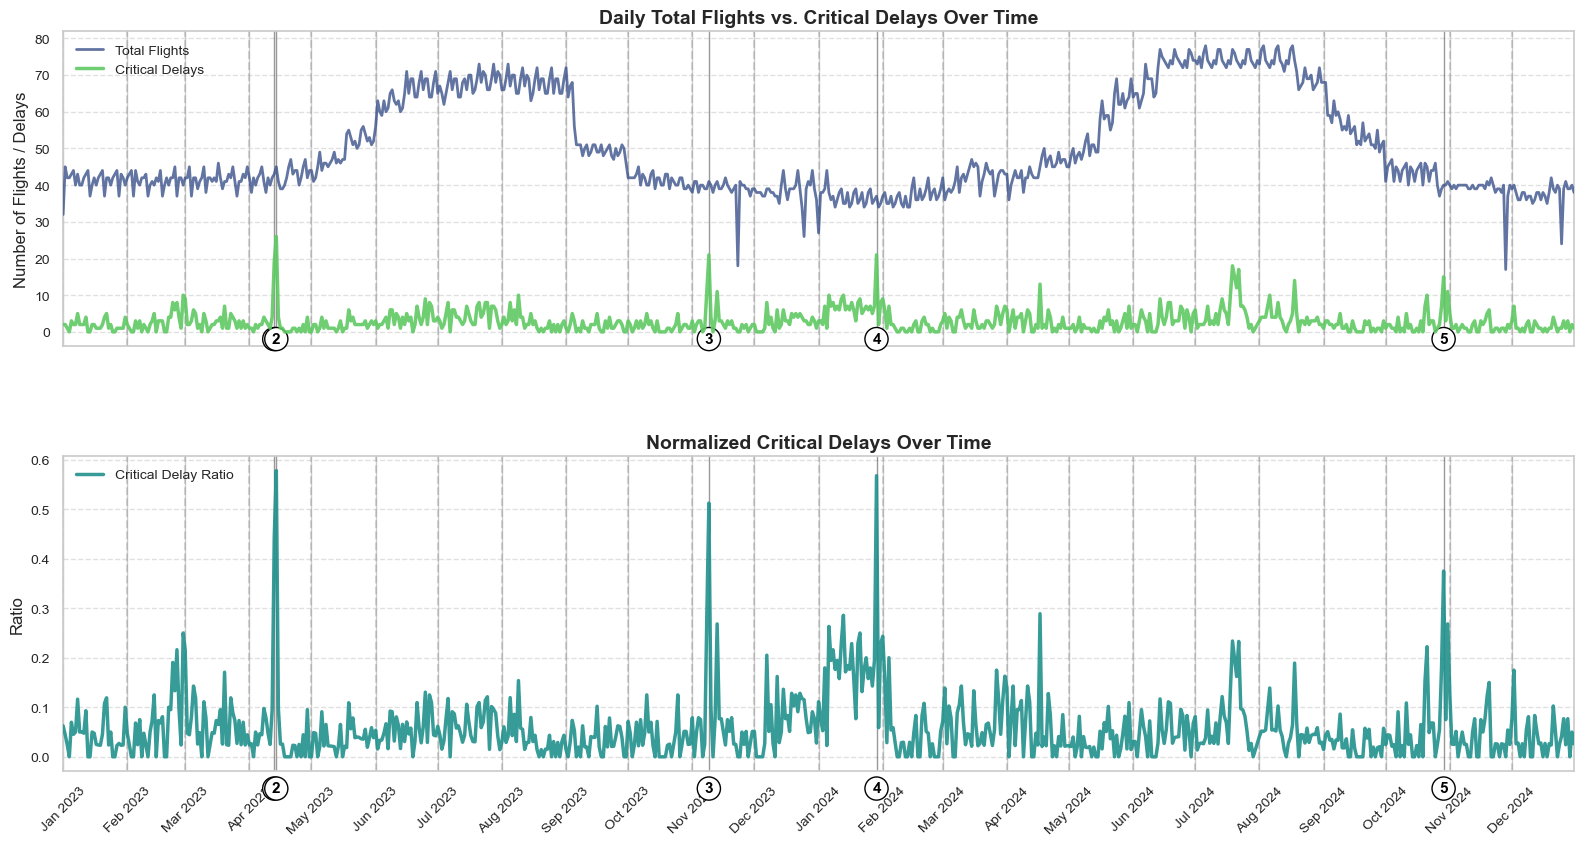

In [16]:
# -------------------------------------------------------
# Define special event dates
# -------------------------------------------------------
raw_event_dates = [
    ('1', '2023-04-13'),
    ('2', '2023-04-14'),
    ('3', '2023-11-09'),
    ('4', '2024-01-29'),
    ('5', '2024-10-29'),
]
event_dates = [(label, pd.Timestamp(date)) for label, date in raw_event_dates]

months = pd.date_range(start='2023-01-01', end='2024-12-01', freq='MS')

# -------------------------------------------------------
# Helper function to draw monthly & event lines
# -------------------------------------------------------
def add_guides(ax):
    for month_start in months:
        ax.axvline(month_start, color='gray', linestyle='--', alpha=0.3, zorder=1)
    for label, date in event_dates:
        ax.axvline(date, color='black', linestyle='-', linewidth=1, alpha=0.4, zorder=1)
        ylim = ax.get_ylim()
        ax.text(date, ylim[0] - (ylim[1] * 0.05), label,
                ha='center', va='top', fontsize=11, color='black', fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle,pad=0.3'),
                zorder=3)

# -------------------------------------------------------
# FIGURE 1 – Daily Flights and Delays (VIRIDIS STYLE)
# -------------------------------------------------------
sns.set_theme(style="whitegrid")
viridis = sns.color_palette("viridis", 3)

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# ---- PLOT 1 – Absolute counts ----
ax = axes[0]
add_guides(ax)
ax.plot(
    daily_counts['FL_DATE'], daily_counts['TOTAL_FLIGHTS'],
    color=viridis[0], label='Total Flights', linewidth=2, alpha=0.8, zorder=4
)
ax.plot(
    daily_counts['FL_DATE'], daily_counts['TOTAL_DELAY'],
    color=viridis[2], label='Critical Delays', linewidth=2.5, alpha=0.9, zorder=5
)

ax.set_ylabel('Number of Flights / Delays', fontsize=12)
ax.set_title('Daily Total Flights vs. Critical Delays Over Time', fontsize=14, fontweight='bold')
ax.legend(frameon=False, fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# ---- PLOT 2 – Normalized ratio ----
ax = axes[1]
add_guides(ax)
ax.plot(
    daily_counts['FL_DATE'], daily_counts['DELAY_RATIO'],
    color=viridis[1], linewidth=2.5, alpha=0.9, zorder=5, label='Critical Delay Ratio'
)
ax.set_ylabel('Ratio', fontsize=12)
ax.set_title('Normalized Critical Delays Over Time', fontsize=14, fontweight='bold')
ax.legend(frameon=False, fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Shared settings for FIGURE 1
for ax in axes:
    ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2024-12-31'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_axisbelow(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(bottom=0.18, hspace=0.35)
plt.show()


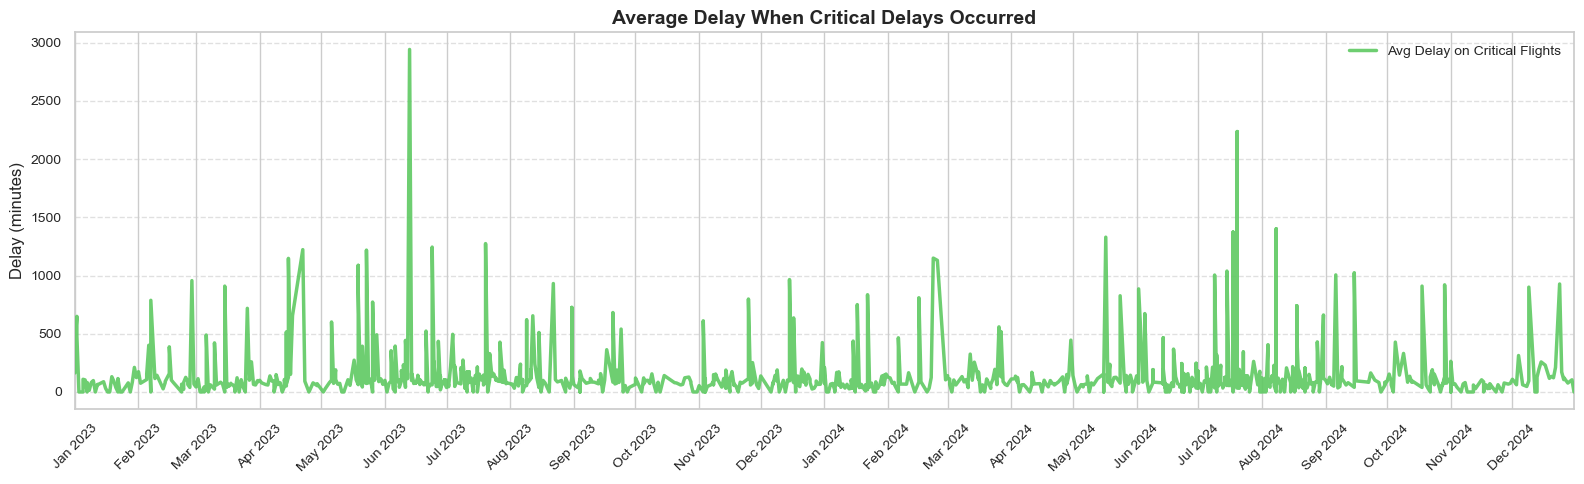

In [17]:
# -------------------------------------------------------
# Compute average delay when CRITICAL_DELAY == 1
# -------------------------------------------------------
critical_daily = (
    df1[df1['CRITICAL_DELAY'] == 1]
    .groupby(['FL_DATE', 'OP_UNIQUE_CARRIER'], as_index=False)
    .agg(AVG_CRIT_DELAY=('TOTAL_DELAY', 'mean'))
)

# -------------------------------------------------------
# FIGURE 2 – Average Delay When Critical Delays Occurred (VIRIDIS STYLE)
# -------------------------------------------------------
sns.set_theme(style="whitegrid")
viridis = sns.color_palette("viridis", 3)

fig, ax = plt.subplots(figsize=(16, 5))

# Plot average delay for critical flights
ax.plot(
    critical_daily['FL_DATE'],
    critical_daily['AVG_CRIT_DELAY'],
    color=viridis[2],
    linewidth=2.5,
    label='Avg Delay on Critical Flights',
    alpha=0.9,
    zorder=5
)

# Axis labels and title
ax.set_ylabel('Delay (minutes)', fontsize=12)
ax.set_title('Average Delay When Critical Delays Occurred', fontsize=14, fontweight='bold')
ax.legend(frameon=False, fontsize=10)

# X-axis formatting (matching previous plot)
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelrotation=45, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Grid & layout
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


In [18]:
critical_daily.sort_values('AVG_CRIT_DELAY', ascending=False).head(10)

FL_DATE  OP_UNIQUE_CARRIER  AVG_CRIT_DELAY
193 2023-06-13  American Airlines          2941.0
755 2024-07-20  American Airlines          2236.0
797 2024-08-08  American Airlines          1401.0
748 2024-07-18  American Airlines          1373.0
635 2024-05-17  American Airlines          1329.0
277 2023-07-20  American Airlines          1274.0
216 2023-06-24             United          1244.0
125 2023-04-22             United          1222.0
156 2023-05-23  American Airlines          1218.0
549 2024-02-23              Delta          1149.5

## Looking further into total delays

### By Destination

#### Prep Data

In [19]:
# -------------------------
# Aggregate by DEST
# -------------------------
dest_stats = (
    df1.groupby('DEST')
    .agg(
        TOTAL_FLIGHTS=('DEST', 'count'),
        TOTAL_CRITICAL=('CRITICAL_DELAY', 'sum')
    )
    .reset_index()
)

# Compute normalized ratio
dest_stats['CRITICAL_RATIO'] = dest_stats['TOTAL_CRITICAL'] / dest_stats['TOTAL_FLIGHTS']

# Sort by total critical delays (descending)
dest_stats = dest_stats.sort_values('TOTAL_CRITICAL', ascending=False)

#### Plot Data

### By departure hour

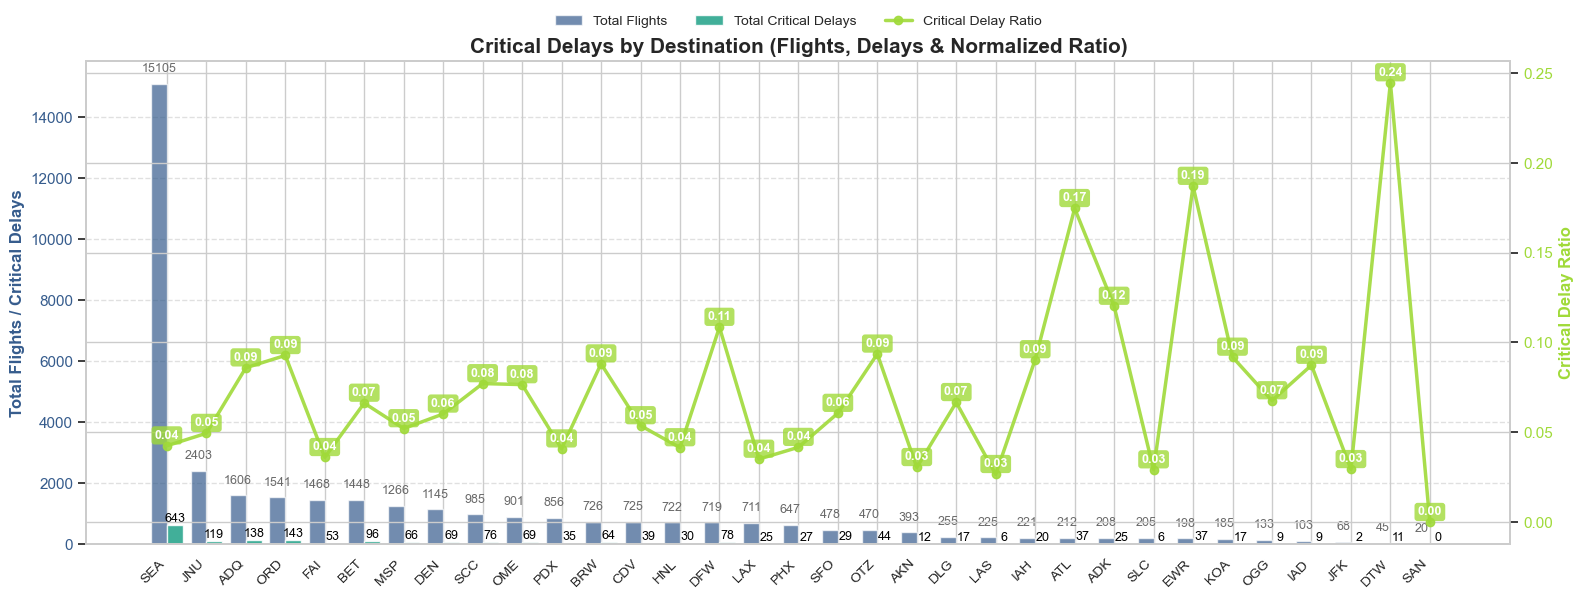

In [20]:
# -------------------------
# Sort by TOTAL_FLIGHTS (descending)
# -------------------------
dest_stats = dest_stats.sort_values('TOTAL_FLIGHTS', ascending=False).reset_index(drop=True)

# -------------------------
# Plot setup (VIRIDIS - higher contrast)
# -------------------------
sns.set_theme(style="whitegrid")

# Manually select contrasting colors from viridis
viridis = sns.color_palette("viridis", 6)
color_bar_flights = viridis[1]  # dark green-blue for total flights
color_bar_critical = viridis[3]  # teal-green for total critical
color_line = viridis[5]  # bright yellow-green for ratio

fig, ax1 = plt.subplots(figsize=(16, 7))  # wide for x-label rotation

# Bar width and position offset
bar_width = 0.4
x = np.arange(len(dest_stats['DEST']))

# ---- BAR 1: total flights ----
bars1 = ax1.bar(
    x - bar_width/2,
    dest_stats['TOTAL_FLIGHTS'],
    width=bar_width,
    color=color_bar_flights,
    alpha=0.7,
    label='Total Flights'
)

# ---- BAR 2: total critical delays ----
bars2 = ax1.bar(
    x + bar_width/2,
    dest_stats['TOTAL_CRITICAL'],
    width=bar_width,
    color=color_bar_critical,
    alpha=0.85,
    label='Total Critical Delays'
)

# ---- LABELS: total flights ----
for bar in bars1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(dest_stats['TOTAL_FLIGHTS']) * 0.02,
        f'{int(height)}',
        ha='center', va='bottom',
        fontsize=9,
        color='dimgray'
    )

# ---- LABELS: total critical delays ----
for bar in bars2:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(dest_stats['TOTAL_CRITICAL']) * 0.02,
        f'{int(height)}',
        ha='center', va='bottom',
        fontsize=9,
        color='black'
    )

ax1.set_ylabel('Total Flights / Critical Delays', color=color_bar_flights, fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(dest_stats['DEST'], rotation=45, ha='right', fontsize=10)
ax1.tick_params(axis='y', labelcolor=color_bar_flights)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# ---- LINE: normalized ratio ----
ax2 = ax1.twinx()
ax2.plot(
    x,
    dest_stats['CRITICAL_RATIO'],
    color=color_line,
    marker='o',
    markersize=6,
    linewidth=2.5,
    label='Critical Delay Ratio',
    zorder=5,
    alpha=0.9
)

# Ratio value labels
for i, val in enumerate(dest_stats['CRITICAL_RATIO']):
    ax2.text(
        i, val + (0.01 * max(dest_stats['CRITICAL_RATIO'])),
        f'{val:.2f}',
        ha='center', va='bottom',
        fontsize=9, fontweight='bold',
        color='white',
        bbox=dict(
            facecolor=color_line,
            edgecolor='none',
            boxstyle='round,pad=0.25',
            alpha=0.8
        ),
        zorder=6
    )

ax2.set_ylabel('Critical Delay Ratio', color=color_line, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_line)

# ---- Titles and styling ----
plt.title('Critical Delays by Destination (Flights, Delays & Normalized Ratio)', fontsize=15, fontweight='bold')
plt.xlabel('Destination Airport', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right', frameon=False, fontsize=10)

ax1.legend(
    lines + lines2,
    labels + labels2,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),  # move legend above chart
    ncol=3,                      # show all items in one line
    frameon=False,
    fontsize=10
)

plt.show()


#### Prep Data

In [21]:
df1 = df1.copy()
# Extract scheduled departure hour (00–23)
df1['DEP_HOUR'] = (df1['CRS_DEP_TIME'] // 100).astype(int)

def normalized_delay_with_spread(df, group_field):
    grouped = df.groupby(group_field)['TOTAL_DELAY']
    mean = grouped.mean()
    std = grouped.std()
    n = grouped.count()
    
    result = pd.DataFrame({
        group_field: mean.index,
        'NORMALIZED_DELAY': mean.values,
        'STD_DELAY': std.values / np.sqrt(n)  # SEM
    }).reset_index(drop=True)
    return result

# Aggregations
hourly = normalized_delay_with_spread(df1, 'DEP_HOUR').sort_values('DEP_HOUR')
weekday = normalized_delay_with_spread(df1, 'DAY_OF_WEEK').sort_values('DAY_OF_WEEK')
monthday = normalized_delay_with_spread(df1, 'DAY_OF_MONTH').sort_values('DAY_OF_MONTH')
monthly = normalized_delay_with_spread(df1, 'MONTH').sort_values('MONTH')

# Labels
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#### Plot Data

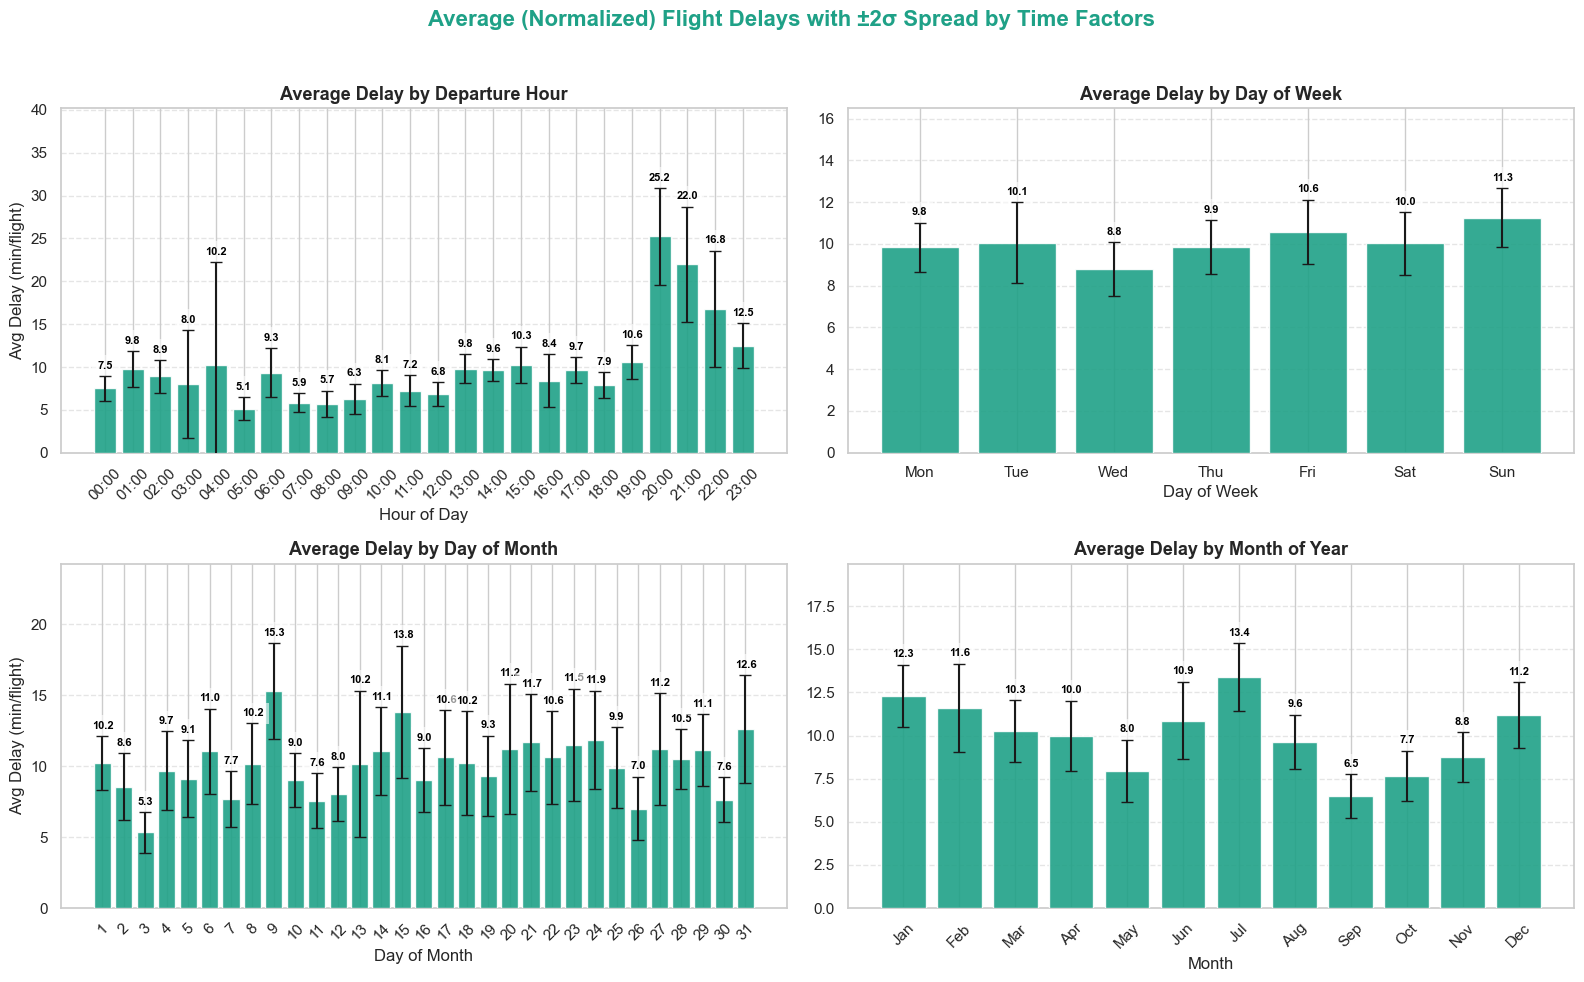

In [22]:
# -------------------------
# Plot setup (VIRIDIS THEME)
# -------------------------
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Pick a visually balanced viridis tone for bars
main_color = sns.color_palette("viridis", 6)[3]   # mid-bright greenish tone

def plot_bar_with_spread(ax, data, title, xlabel, ylabel=None, xticklabels=None, rotation=0):
    # X positions for bars
    x = np.arange(len(data))
    y = data['NORMALIZED_DELAY']
    err = 2 * data['STD_DELAY']
    
    # Bars
    bars = ax.bar(x, y, yerr=err, capsize=4, color=main_color, alpha=0.9, zorder=3)
    
    # ---- Precise tick alignment ----
    ax.set_xticks(x)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=rotation, ha='center')
    
    # Titles and labels
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    
    # ---- Value labels ----
    y_max = (y + err).max()
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + err.iloc[i] + 0.02 * y_max,
            f'{height:.1f}',
            ha='center', va='bottom', fontsize=8, fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
        )
    
    # Add headroom for text
    ax.set_ylim(0, y_max * 1.3)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.margins(y=0.1)

# ---- 1) By Hour ----
plot_bar_with_spread(
    axes[0], hourly,
    title='Average Delay by Departure Hour',
    xlabel='Hour of Day',
    ylabel='Avg Delay (min/flight)',
    xticklabels=[f'{h:02d}:00' for h in hourly['DEP_HOUR']],
    rotation=45
)

# ---- 2) By Day of Week ----
plot_bar_with_spread(
    axes[1], weekday,
    title='Average Delay by Day of Week',
    xlabel='Day of Week',
    xticklabels=weekday_labels
)

# ---- 3) By Day of Month ----
plot_bar_with_spread(
    axes[2], monthday,
    title='Average Delay by Day of Month',
    xlabel='Day of Month',
    ylabel='Avg Delay (min/flight)',
    xticklabels=[str(i) for i in monthday['DAY_OF_MONTH']],
    rotation=45
)

# ---- 4) By Month of Year ----
plot_bar_with_spread(
    axes[3], monthly,
    title='Average Delay by Month of Year',
    xlabel='Month',
    xticklabels=month_labels[:len(monthly)],
    rotation=45
)

# ---- Shared styling ----
plt.suptitle(
    'Average (Normalized) Flight Delays with ±2σ Spread by Time Factors',
    fontsize=16, fontweight='bold', color=main_color
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Part 2 - Integration of location & weather data

### Add airports data

In [23]:
# airports = load('IATA')  # Dictionary with airport data

In [24]:
# print(airports['JFK'])

### Add airports LAT-LON

airports.csv data was downloaded from [OurAirports.com](https://ourairports.com/data/)

In [25]:
# # Clean up airport codes
# df1["ORIGIN"] = df1["ORIGIN"].astype(str).str.strip().str.upper()
# df1["DEST"] = df1["DEST"].astype(str).str.strip().str.upper()

# # ------------------------------------------------------------
# # Load airport database
# # ------------------------------------------------------------
# def load_airports_db():
#     local_path = "airports.csv"  # must exist in same folder
#     if not os.path.exists(local_path):
#         raise FileNotFoundError()

#     airports_df = pd.read_csv(local_path, low_memory=False)
#     airports_df = airports_df[
#         ["ident", "iata_code", "latitude_deg", "longitude_deg", "name", "iso_country"]
#     ].rename(
#         columns={
#             "ident": "ICAO",
#             "iata_code": "IATA",
#             "latitude_deg": "LAT",
#             "longitude_deg": "LON",
#         }
#     )
#     airports_df["IATA"] = airports_df["IATA"].astype(str).str.upper()
#     airports_df["ICAO"] = airports_df["ICAO"].astype(str).str.upper()
#     airports_df.dropna(subset=["LAT", "LON"], inplace=True)
#     return airports_df


# airports_db = load_airports_db()
# print(f"Loaded {len(airports_db):,} airports")

# # ------------------------------------------------------------
# # Build unique airport list
# # ------------------------------------------------------------
# unique_airports = pd.Series(
#     pd.concat([df1["ORIGIN"], df1["DEST"]])
#     .dropna()
#     .unique(),
#     name="CODE"
# )

# print(f"Found {len(unique_airports)} unique airport codes")

# code_type = "IATA"

# # ------------------------------------------------------------
# # Merge coordinates efficiently
# # ------------------------------------------------------------
# lookup_df = pd.merge(
#     unique_airports,
#     airports_db[[code_type, "LAT", "LON"]],
#     left_on="CODE",
#     right_on=code_type,
#     how="left"
# )[["CODE", "LAT", "LON"]]

# missing = lookup_df["LAT"].isna().sum()
# if missing:
#     print(f" {missing} airports had no coordinate match")

# # ------------------------------------------------------------
# # Merge coordinates back into df1
# # ------------------------------------------------------------
# df1 = df1.merge(
#     lookup_df.rename(columns={"CODE": "ORIGIN", "LAT": "ORIGIN_LAT", "LON": "ORIGIN_LON"}),
#     on="ORIGIN",
#     how="left"
# )
# df1 = df1.merge(
#     lookup_df.rename(columns={"CODE": "DEST", "LAT": "DEST_LAT", "LON": "DEST_LON"}),
#     on="DEST",
#     how="left"
# )

# # ------------------------------------------------------------
# # Verify results
# # ------------------------------------------------------------
# cols_to_check = ["ORIGIN", "DEST", "ORIGIN_LAT", "ORIGIN_LON", "DEST_LAT", "DEST_LON"]
# missing_coords = df1[df1["ORIGIN_LAT"].isna() | df1["DEST_LAT"].isna()]

# print("\n Sample enriched data:")
# print(df1[cols_to_check].head(10))

# if not missing_coords.empty:
#     print(f"\n{len(missing_coords)} rows have missing coordinates. Here are a few:")
#     print(missing_coords[["ORIGIN", "DEST"]].head(10))

# # ------------------------------------------------------------
# # Save output
# # ------------------------------------------------------------
# df1.to_csv("flights_with_coords.csv", index=False)
# print("\nSaved to flights_with_coords.csv")


### Add weather data

In [26]:
# ssl._create_default_https_context = ssl._create_unverified_context

# # ------------------------------------------------------------
# # Ensure datetime columns exist
# # ------------------------------------------------------------
# if "DEP_DATETIME" not in df1.columns or "ARR_DATETIME" not in df1.columns:

#     # Ensure FL_DATE is datetime
#     df1["FL_DATE"] = pd.to_datetime(df1["FL_DATE"], errors="coerce")

#     def parse_time(t):
#         """Convert HHMM integer to hours/minutes safely"""
#         try:
#             t = int(t)
#             return timedelta(hours=t // 100, minutes=t % 100)
#         except:
#             return pd.NaT

#     df1["DEP_DATETIME"] = df1["FL_DATE"] + df1["CRS_DEP_TIME"].apply(parse_time)
#     df1["ARR_DATETIME"] = df1["FL_DATE"] + df1["CRS_ARR_TIME"].apply(parse_time)

# print(f" DEP_DATETIME/ARR_DATETIME ready (valid: {df1['DEP_DATETIME'].notna().sum()}/{df1['ARR_DATETIME'].notna().sum()})")

# # ------------------------------------------------------------
# # Load airport coordinates
# # ------------------------------------------------------------
# airports = pd.read_csv("airports.csv")
# airport_dict = {
#     row["iata_code"]: (row["latitude_deg"], row["longitude_deg"])
#     for _, row in airports.dropna(subset=["iata_code", "latitude_deg", "longitude_deg"]).iterrows()
# }
# print(f" Loaded {len(airport_dict)} airports")

# # ------------------------------------------------------------
# # Build unique airport–datetime pairs
# # ------------------------------------------------------------
# dep_pairs = df1[["ORIGIN", "DEP_DATETIME"]].dropna().drop_duplicates()
# dep_pairs.columns = ["IATA", "DATETIME"]
# arr_pairs = df1[["DEST", "ARR_DATETIME"]].dropna().drop_duplicates()
# arr_pairs.columns = ["IATA", "DATETIME"]
# pairs = pd.concat([dep_pairs, arr_pairs]).drop_duplicates().reset_index(drop=True)
# pairs["DATETIME_HOUR"] = pairs["DATETIME"].dt.floor("h")

# print(f" Unique airport–datetime pairs: {len(pairs)}")



# # ------------------------------------------------------------
# # Load or create local weather cache
# # ------------------------------------------------------------
# cache_file = "weather_cache.parquet"
# if os.path.exists(cache_file):
#     try:
#         weather_cache = pd.read_parquet(cache_file)
#         if not {"IATA", "DATETIME_HOUR"}.issubset(weather_cache.columns):
#             raise ValueError("Invalid cache structure")
#         print(f" Loaded cache with {len(weather_cache)} records")
#     except Exception:
#         print(" Cache invalid or corrupt — starting fresh")
#         weather_cache = pd.DataFrame(columns=[
#             "IATA", "DATETIME_HOUR", "temp", "rhum", "prcp", "snow",
#             "wdir", "wspd", "wpgt", "pres"
#         ])
# else:
#     print(" No cache found — starting fresh")
#     weather_cache = pd.DataFrame(columns=[
#         "IATA", "DATETIME_HOUR", "temp", "rhum", "prcp", "snow",
#         "wdir", "wspd", "wpgt", "pres"
#     ])

# # ------------------------------------------------------------
# # Determine which weather entries are missing
# # ------------------------------------------------------------

# # Normalize all datetime columns to be timezone-naive
# for col in ["DATETIME_HOUR"]:
#     pairs[col] = pd.to_datetime(pairs[col]).dt.tz_localize(None)
#     if col in weather_cache.columns:
#         weather_cache[col] = pd.to_datetime(weather_cache[col], errors="coerce")
#         # If timezone-aware, strip to naive
#         weather_cache[col] = weather_cache[col].dt.tz_localize(None)

# merged = pairs.merge(weather_cache, on=["IATA", "DATETIME_HOUR"], how="left", indicator=True)
# missing = merged.loc[merged["_merge"] == "left_only", ["IATA", "DATETIME_HOUR"]]
# print(f" Need to fetch {len(missing)} new weather entries")


# # ------------------------------------------------------------
# # Fetch and append weather data in chunks of 500
# # ------------------------------------------------------------
# records = []
# batch_size = 500

# for i, row in tqdm(missing.iterrows(), total=len(missing)):
#     iata = row["IATA"]
#     dt = row["DATETIME_HOUR"]

#     if iata not in airport_dict:
#         continue

#     lat, lon = airport_dict[iata]
#     try:
#         stations = Stations().nearby(lat, lon).fetch(1)
#         if stations.empty:
#             continue
#         station_id = stations.index[0]
#         data = Hourly(station_id, start=dt, end=dt + timedelta(hours=1)).fetch()
#         if not data.empty:
#             rec = data.iloc[0][["temp", "rhum", "prcp", "snow", "wdir", "wspd", "wpgt", "pres"]].to_dict()
#             rec.update({"IATA": iata, "DATETIME_HOUR": dt})
#             records.append(rec)
#     except Exception as e:
#         print(f" Error fetching for {iata} at {dt}: {e}")
#         continue

#     # Save every 500 records
#     if len(records) >= batch_size:
#         new_weather = pd.DataFrame(records)
#         weather_cache = pd.concat([weather_cache, new_weather], ignore_index=True)
#         weather_cache.drop_duplicates(subset=["IATA", "DATETIME_HOUR"], inplace=True)
#         weather_cache.to_parquet(cache_file, index=False)
#         print(f" Saved checkpoint ({len(weather_cache)} total records)")
#         records = []

# # Save any leftovers
# if records:
#     new_weather = pd.DataFrame(records)
#     weather_cache = pd.concat([weather_cache, new_weather], ignore_index=True)
#     weather_cache.drop_duplicates(subset=["IATA", "DATETIME_HOUR"], inplace=True)
#     weather_cache.to_parquet(cache_file, index=False)
#     print(f" Final save ({len(weather_cache)} total records)")

# # ------------------------------------------------------------
# # Merge weather data into flights
# # ------------------------------------------------------------

# df1["DEP_HOUR"] = pd.to_datetime(df1["DEP_DATETIME"].dt.floor("h")).dt.tz_localize(None)
# df1["ARR_HOUR"] = pd.to_datetime(df1["ARR_DATETIME"].dt.floor("h")).dt.tz_localize(None)

# weather_cache["DATETIME_HOUR"] = pd.to_datetime(weather_cache["DATETIME_HOUR"]).dt.tz_localize(None)


# df1 = df1.merge(
#     weather_cache.add_prefix("ORIGIN_"),
#     left_on=["ORIGIN", "DEP_HOUR"],
#     right_on=["ORIGIN_IATA", "ORIGIN_DATETIME_HOUR"],
#     how="left"
# )

# df1 = df1.merge(
#     weather_cache.add_prefix("DEST_"),
#     left_on=["DEST", "ARR_HOUR"],
#     right_on=["DEST_IATA", "DEST_DATETIME_HOUR"],
#     how="left"
# )

# df1.drop(columns=["ORIGIN_IATA", "ORIGIN_DATETIME_HOUR", "DEST_IATA", "DEST_DATETIME_HOUR"], inplace=True)

# # Save progress every run
# df1.to_csv("flights_with_weather.csv", index=False)
# print(" flights_with_weather.csv updated successfully")


## Part 3 - Looking at weather data

### Re-load data & basic cleanup

In [27]:
df = pd.read_csv("flights_with_weather.csv")

cols_to_drop = [
    'DEP_HOUR',
    'ORIGIN_LAT',
    'ORIGIN_LON',
    'DEST_LAT',
    'DEST_LON',
    'DEP_DATETIME',
    'ARR_DATETIME',
    'ARR_HOUR',
    'ORIGIN_snow',
    'ORIGIN_wpgt',
    'DEST_snow',
    'DEST_wpgt']

df = df.drop(cols_to_drop, axis=1)


### Looking at weather delays

#### Plot

Filtered dataset: 335 rows (from 36,393 total)


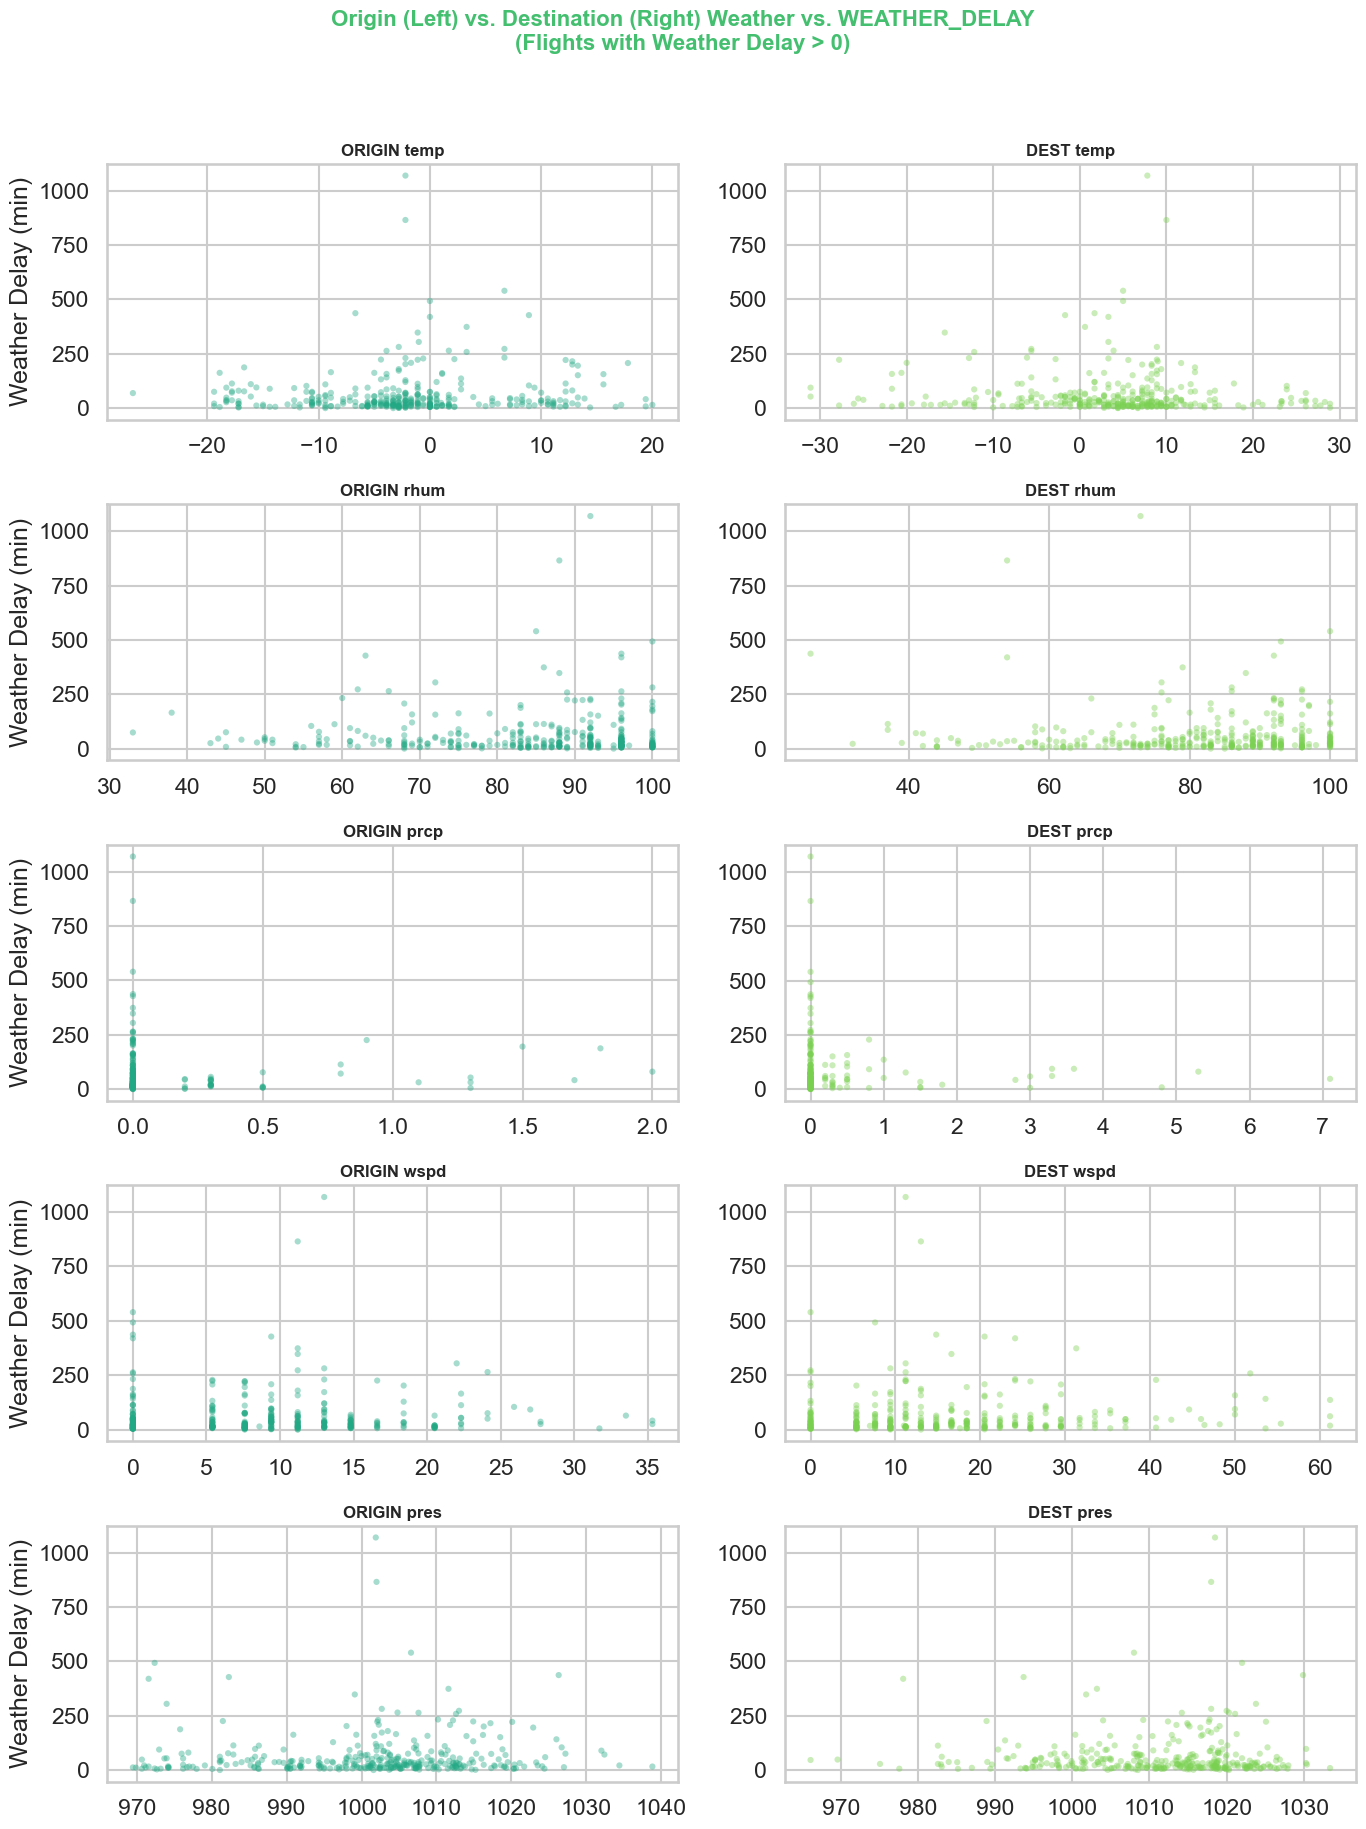

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")

# Filter: only flights with weather delay > 0
df_weather = df[df['WEATHER_DELAY'] > 0].copy()
print(f"Filtered dataset: {len(df_weather):,} rows (from {len(df):,} total)")

# Optional: sample for plotting speed if dataset > 100k
if len(df_weather) > 100_000:
    df_weather = df_weather.sample(100_000, random_state=42)
    print(f"Sampled down to 100,000 rows for plotting speed.")

# Define weather variables
origin_weather = ['ORIGIN_temp', 'ORIGIN_rhum', 'ORIGIN_prcp', 'ORIGIN_wspd', 'ORIGIN_pres']
dest_weather   = ['DEST_temp',  'DEST_rhum',  'DEST_prcp',  'DEST_wspd',  'DEST_pres']

# Prepare figure: 5 rows × 2 columns (origin left, destination right)
fig, axes = plt.subplots(5, 2, figsize=(14, 18))

palette = sns.color_palette("viridis", as_cmap=True)

# Plot origin (left column)
for i, col in enumerate(origin_weather):
    ax = axes[i, 0]
    sns.scatterplot(
        data=df_weather,
        x=col,
        y='WEATHER_DELAY',
        alpha=0.4,
        s=20,
        color=palette(0.6),
        edgecolor='none',
        ax=ax
    )
    ax.set_title(col.replace('_', ' '), fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Weather Delay (min)')

# Plot destination (right column)
for i, col in enumerate(dest_weather):
    ax = axes[i, 1]
    sns.scatterplot(
        data=df_weather,
        x=col,
        y='WEATHER_DELAY',
        alpha=0.4,
        s=20,
        color=palette(0.8),
        edgecolor='none',
        ax=ax
    )
    ax.set_title(col.replace('_', ' '), fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

# Global title
fig.suptitle(
    'Origin (Left) vs. Destination (Right) Weather vs. WEATHER_DELAY\n(Flights with Weather Delay > 0)',
    fontsize=16,
    fontweight='bold',
    color=palette(0.7),
    y=1.02
)

plt.tight_layout()
plt.show()


In [30]:
# # -------------------------
# # Weather vs. Delay Analysis (Origin vs Destination side-by-side)
# # -------------------------
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set_theme(style="whitegrid", context="talk")

# # Filter: only flights with weather delay > 0
# df_weather = df[df['WEATHER_DELAY'] > 0].copy()
# print(f"Filtered dataset: {len(df_weather):,} rows (from {len(df):,} total)")

# # Optional: sample for plotting speed if dataset > 100k
# if len(df_weather) > 100_000:
#     df_weather = df_weather.sample(100_000, random_state=42)
#     print(f"Sampled down to 100,000 rows for plotting speed.")

# # Weather variable pairs (aligned by type)
# weather_pairs = [
#     ('ORIGIN_temp', 'DEST_temp'),
#     ('ORIGIN_rhum', 'DEST_rhum'),
#     ('ORIGIN_prcp', 'DEST_prcp'),
#     ('ORIGIN_wspd', 'DEST_wspd'),
#     ('ORIGIN_pres', 'DEST_pres')
# ]

# # Prepare figure: 5 rows × 2 columns
# fig, axes = plt.subplots(5, 2, figsize=(14, 18))
# palette = sns.color_palette("viridis", as_cmap=True)

# for i, (origin_col, dest_col) in enumerate(weather_pairs):
#     # ---- Left column (Origin) ----
#     ax_left = axes[i, 0]
#     sns.scatterplot(
#         data=df_weather,
#         x=origin_col,
#         y='WEATHER_DELAY',
#         alpha=0.4,
#         s=20,
#         color=palette(0.55),
#         edgecolor='none',
#         ax=ax_left
#     )
#     ax_left.set_title(f"Origin: {origin_col.split('_')[1].title()}", fontsize=12, fontweight='bold')
#     ax_left.set_xlabel('')
#     ax_left.set_ylabel('Weather Delay (min)')

#     # ---- Right column (Destination) ----
#     ax_right = axes[i, 1]
#     sns.scatterplot(
#         data=df_weather,
#         x=dest_col,
#         y='WEATHER_DELAY',
#         alpha=0.4,
#         s=20,
#         color=palette(0.85),
#         edgecolor='none',
#         ax=ax_right
#     )
#     ax_right.set_title(f"Destination: {dest_col.split('_')[1].title()}", fontsize=12, fontweight='bold')
#     ax_right.set_xlabel('')
#     ax_right.set_ylabel('')

# # Global title
# fig.suptitle(
#     'Origin vs Destination Weather vs WEATHER_DELAY\n(Flights with Weather Delay > 0)',
#     fontsize=16,
#     fontweight='bold',
#     color=palette(0.7),
#     y=1.02
# )

# plt.tight_layout()
# plt.show()


### Heatmaps

#### Plot of weather data

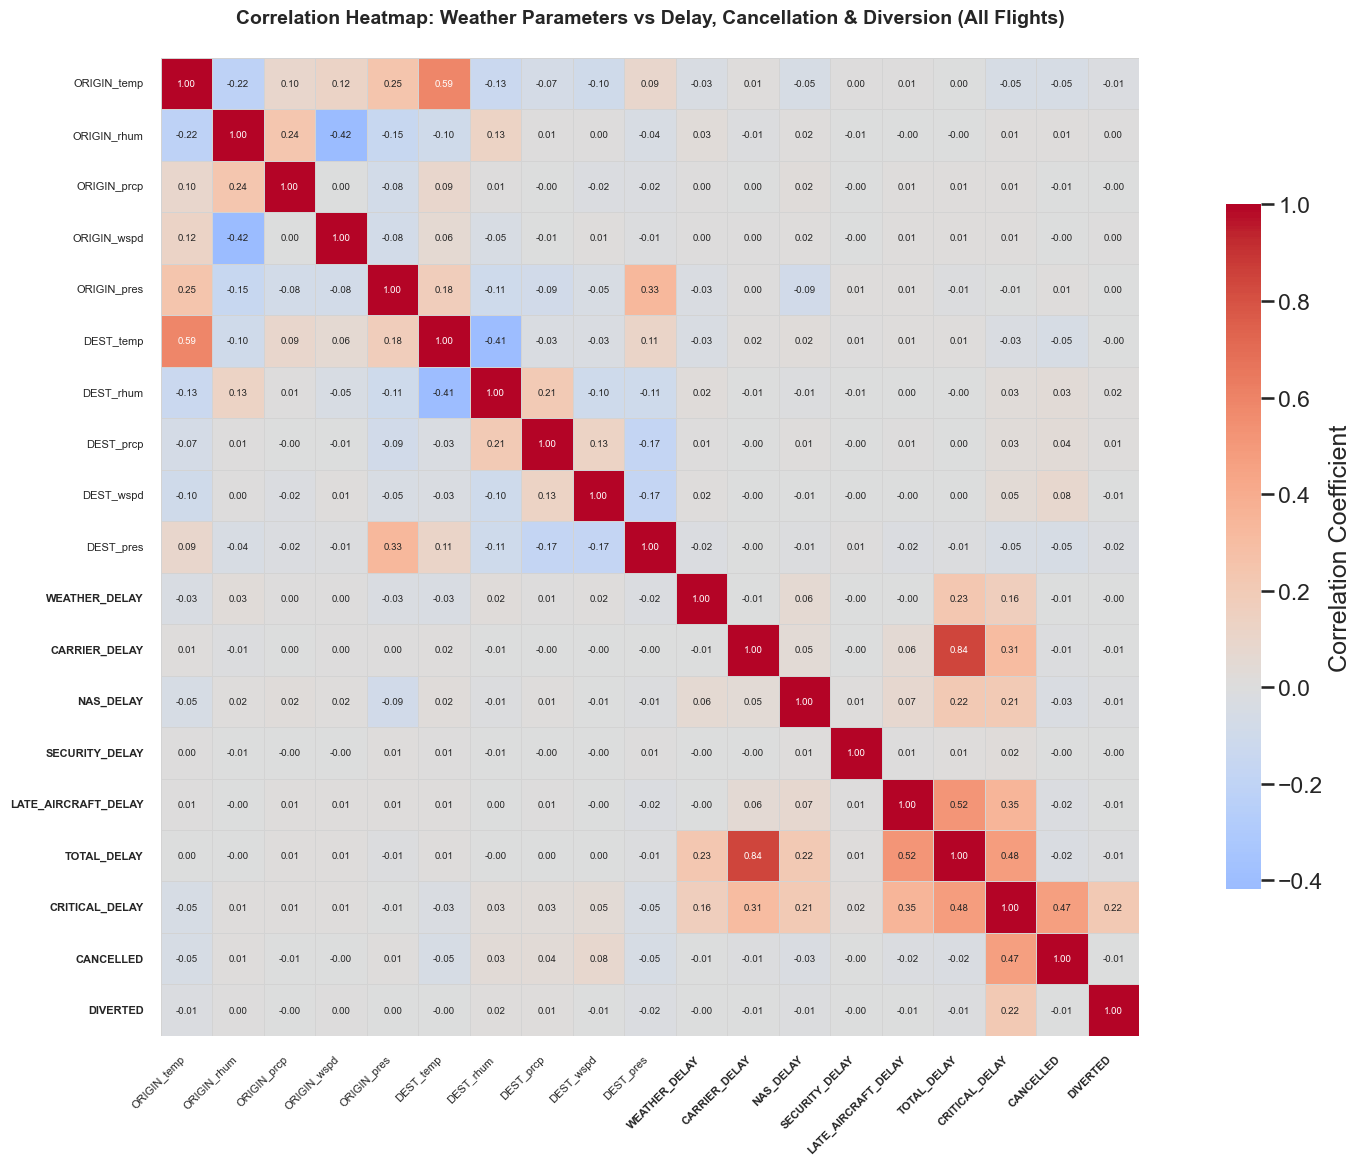

In [31]:
# Set consistent style
sns.set(style="white", context="talk")

# Copy dataset
df_weather = df.copy()

# Define columns
origin_weather = ['ORIGIN_temp', 'ORIGIN_rhum', 'ORIGIN_prcp', 'ORIGIN_wspd', 'ORIGIN_pres']
dest_weather   = ['DEST_temp', 'DEST_rhum', 'DEST_prcp', 'DEST_wspd', 'DEST_pres']
weather_vars   = origin_weather + dest_weather

target_vars = [
    'WEATHER_DELAY', 'CARRIER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY', 'TOTAL_DELAY', 'CRITICAL_DELAY',
    'CANCELLED', 'DIVERTED'
]

# Combine relevant columns
corr_cols = [c for c in (weather_vars + target_vars) if c in df_weather.columns]
corr_matrix = df_weather[corr_cols].corr().fillna(0)

# --- Plot ---
plt.figure(figsize=(18, 12))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.4,
    linecolor="lightgrey",
    cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
    annot_kws={'size': 7},
    square=True
)

# --- Style labels ---
for label in ax.get_xticklabels():
    label.set_fontsize(8)
    label.set_rotation(45)
    label.set_ha('right')
    if label.get_text() in target_vars:
        label.set_fontweight('bold')

for label in ax.get_yticklabels():
    label.set_fontsize(8)
    label.set_rotation(0)
    if label.get_text() in target_vars:
        label.set_fontweight('bold')

# --- Title ---
plt.title(
    'Correlation Heatmap: Weather Parameters vs Delay, Cancellation & Diversion (All Flights)',
    fontsize=14,
    pad=25,
    weight='bold'
)
plt.tight_layout()
plt.show()


#### Plots of non-weather Data

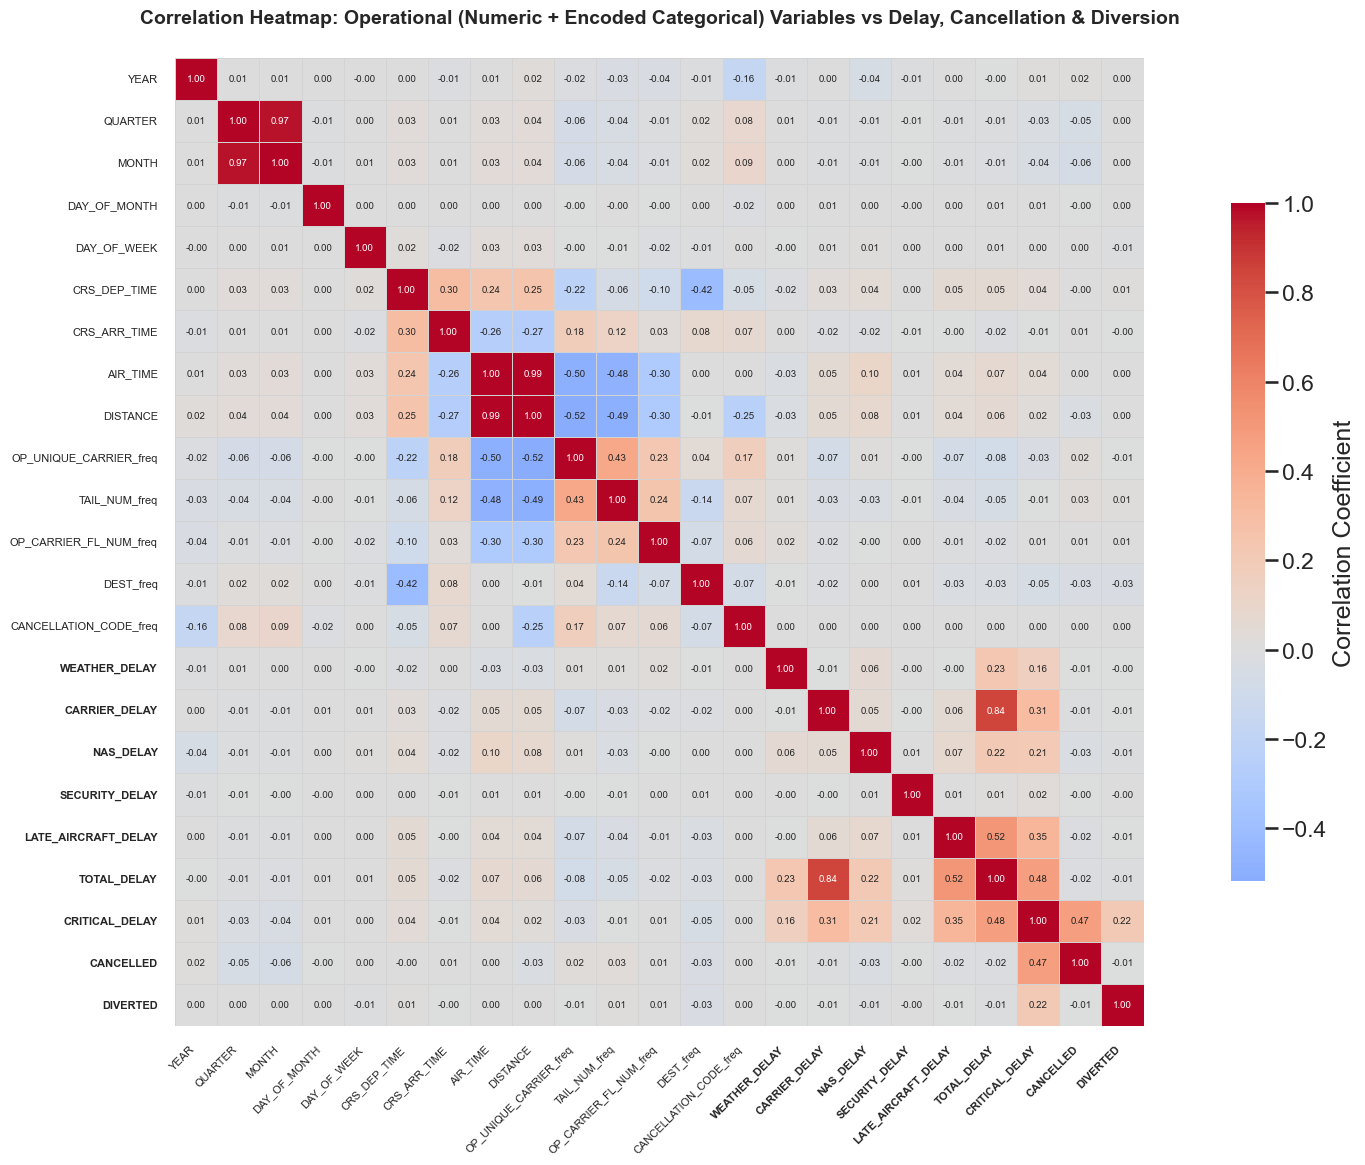

In [32]:
# Set consistent style
sns.set(style="white", context="talk")

# Copy dataset
df_oper = df.copy()

# --- Define variables ---
numeric_oper_vars = [
    'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
    'CRS_DEP_TIME', 'CRS_ARR_TIME', 'AIR_TIME', 'DISTANCE',
    'DEP_HOUR', 'ARR_HOUR', 'ORIGIN_LAT', 'ORIGIN_LON', 
    'DEST_LAT', 'DEST_LON'
]

categorical_oper_vars = [
    'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
    'ORIGIN', 'DEST', 'CANCELLATION_CODE'
]

target_vars = [
    'WEATHER_DELAY', 'CARRIER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY', 'TOTAL_DELAY', 'CRITICAL_DELAY', 
    'CANCELLED', 'DIVERTED'
]

# --- Frequency encode categorical variables ---
for col in categorical_oper_vars:
    if col in df_oper.columns:
        freq_map = df_oper[col].value_counts(normalize=True)
        df_oper[col + '_freq'] = df_oper[col].map(freq_map)

encoded_cats = [c + '_freq' for c in categorical_oper_vars if c + '_freq' in df_oper.columns]
corr_cols = [c for c in (numeric_oper_vars + encoded_cats + target_vars) if c in df_oper.columns]

# --- Drop constant columns ---
const_cols = [col for col in corr_cols if df_oper[col].nunique() <= 1]
if const_cols:
    corr_cols = [c for c in corr_cols if c not in const_cols]

# --- Correlation matrix ---
corr_matrix = df_oper[corr_cols].corr().fillna(0)

# --- Plot ---
plt.figure(figsize=(18, 12))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.4,
    linecolor="lightgrey",
    cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
    annot_kws={'size': 7},
    square=True
)

# --- Style labels ---
for label in ax.get_xticklabels():
    label.set_fontsize(8)
    label.set_rotation(45)
    label.set_ha('right')
    if label.get_text() in target_vars:
        label.set_fontweight('bold')

for label in ax.get_yticklabels():
    label.set_fontsize(8)
    label.set_rotation(0)
    if label.get_text() in target_vars:
        label.set_fontweight('bold')

# --- Title ---
plt.title(
    'Correlation Heatmap: Operational (Numeric + Encoded Categorical) Variables vs Delay, Cancellation & Diversion',
    fontsize=14,
    pad=25,
    weight='bold'
)
plt.tight_layout()


### Weather over time

#### Plots

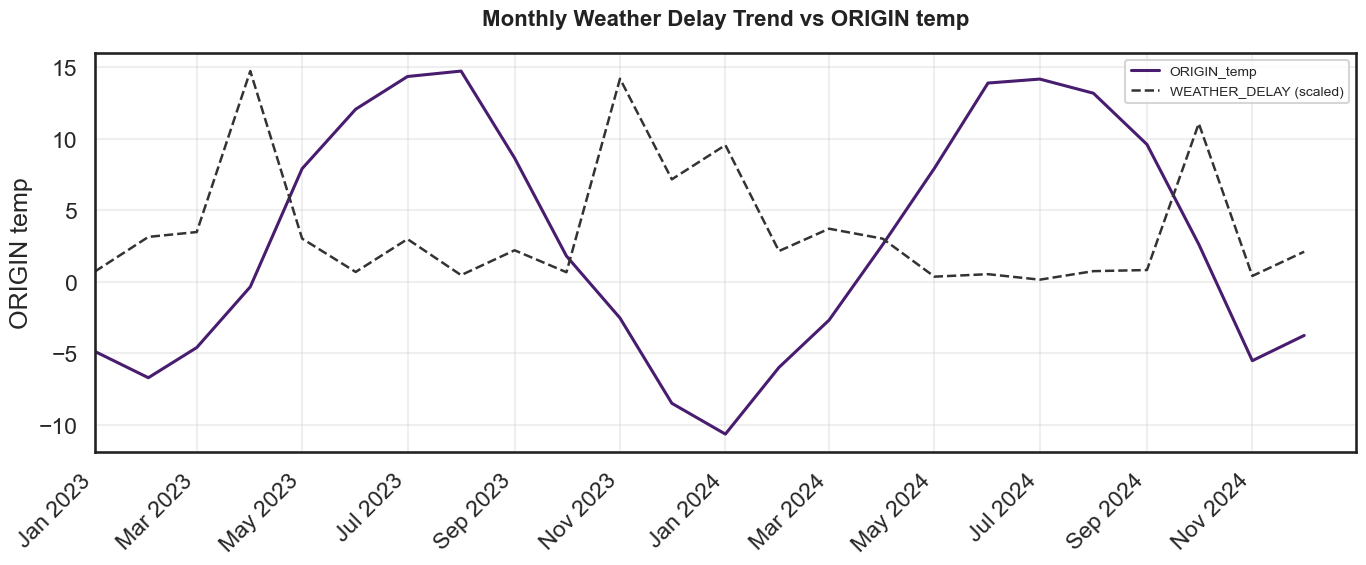

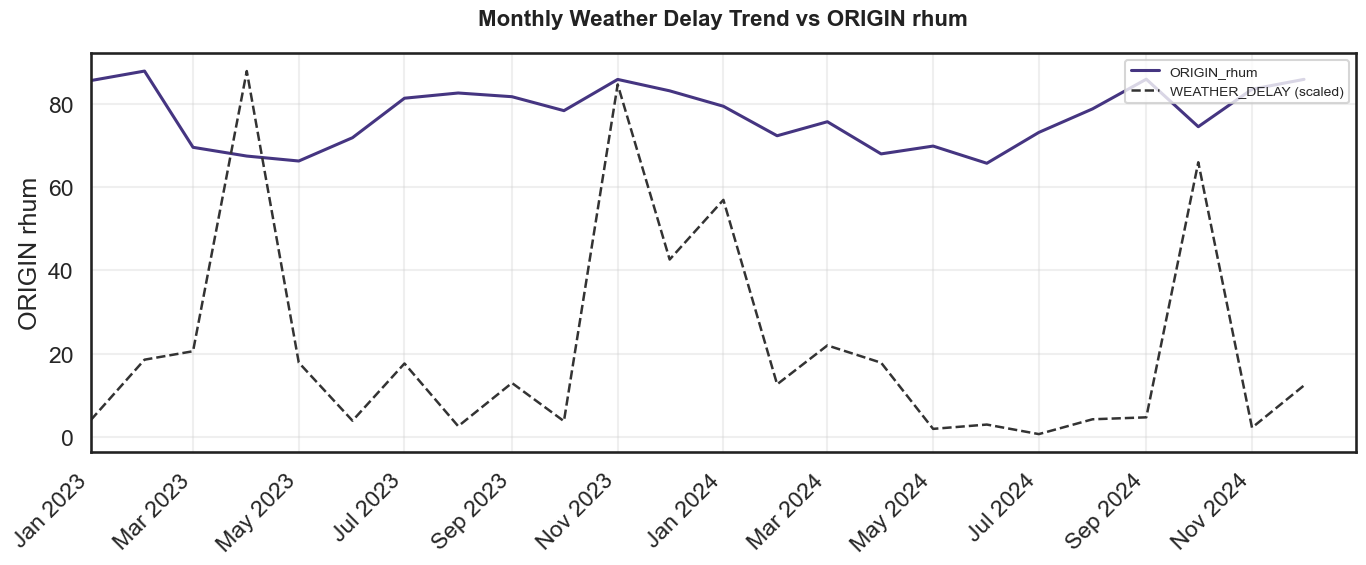

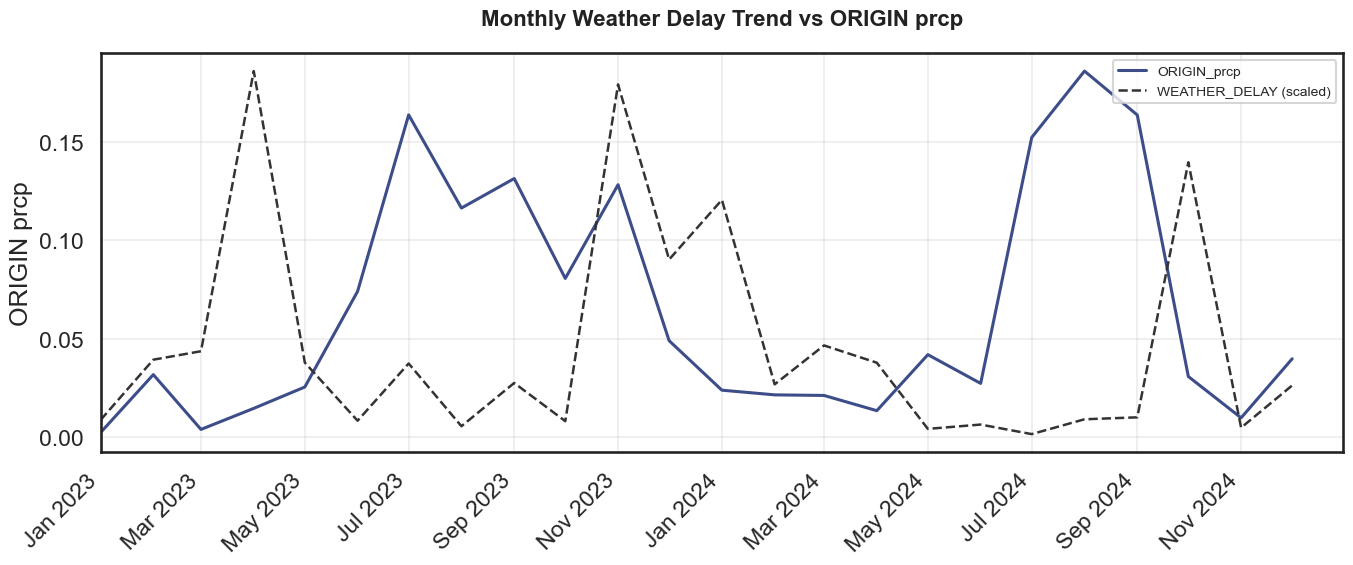

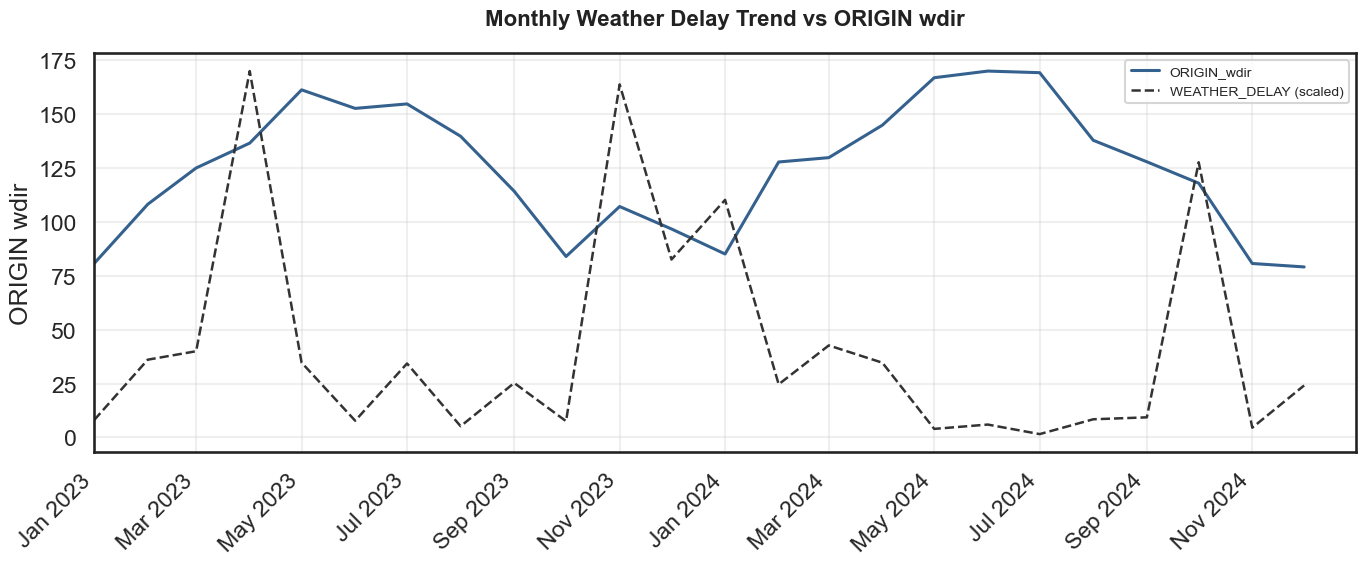

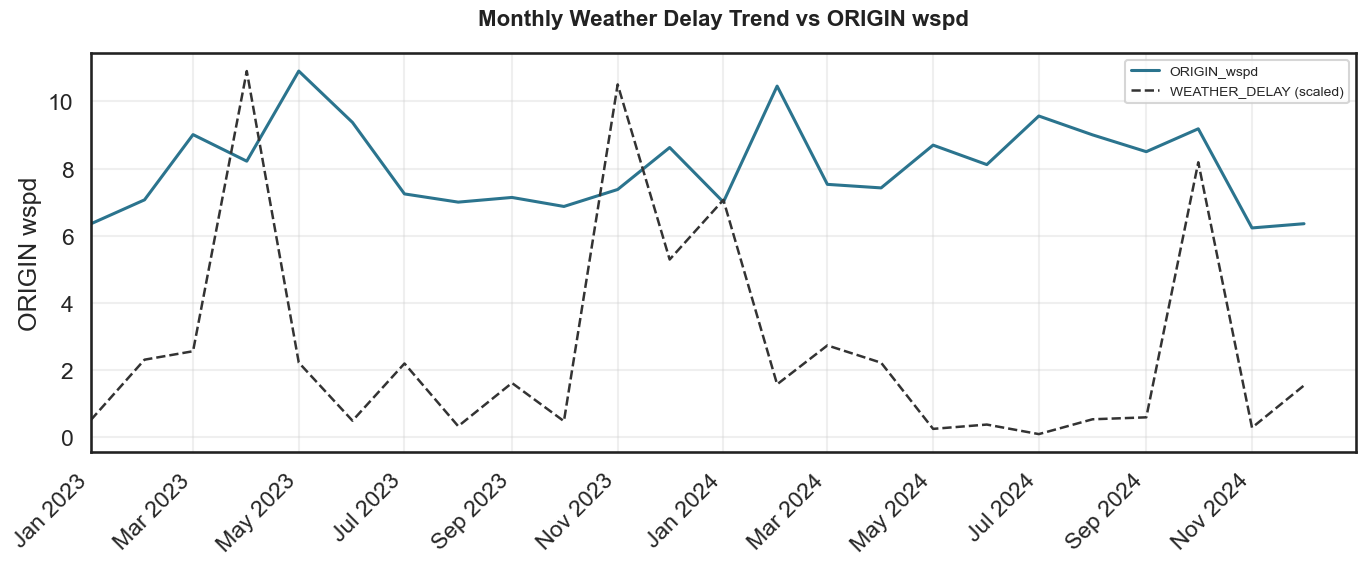

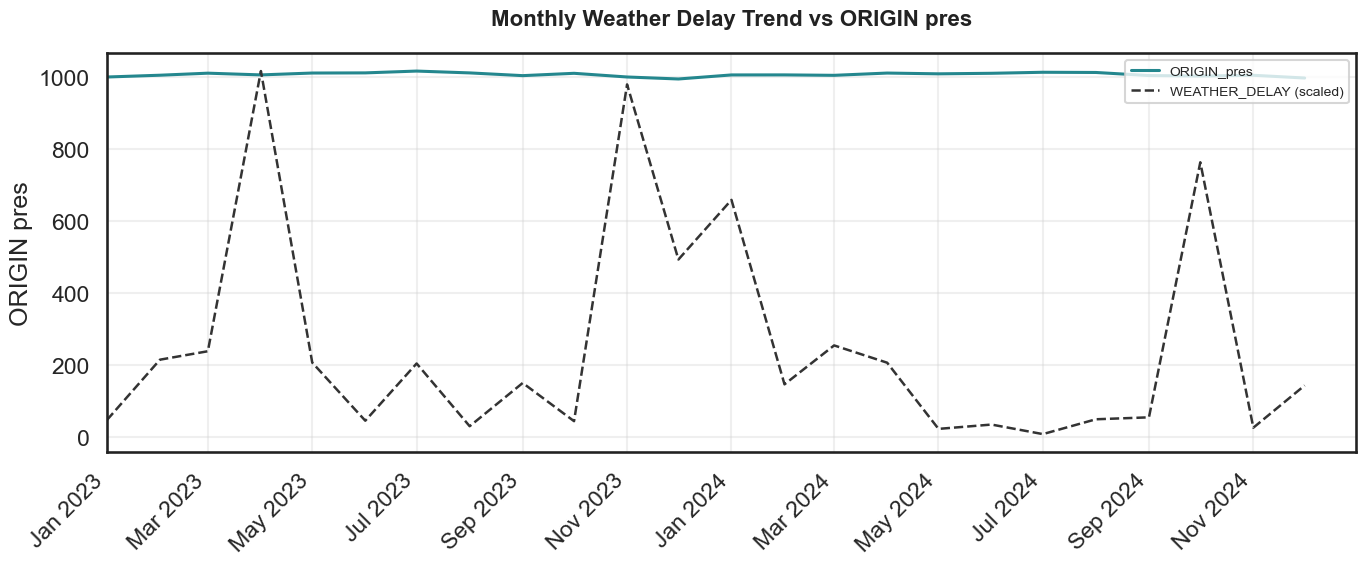

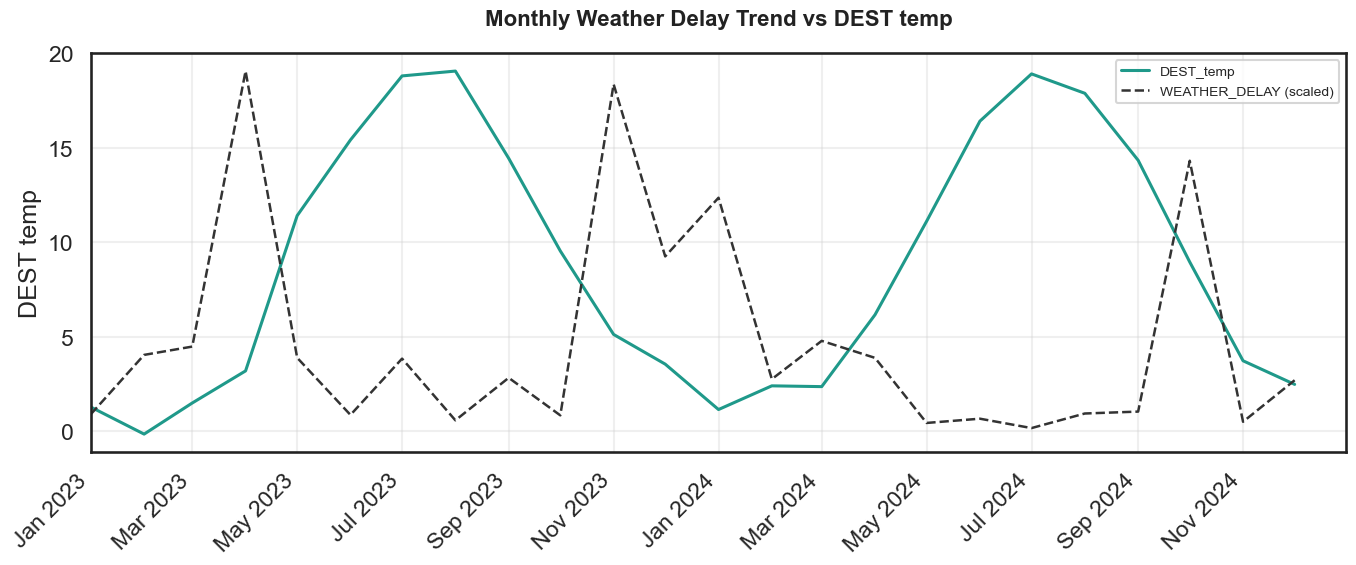

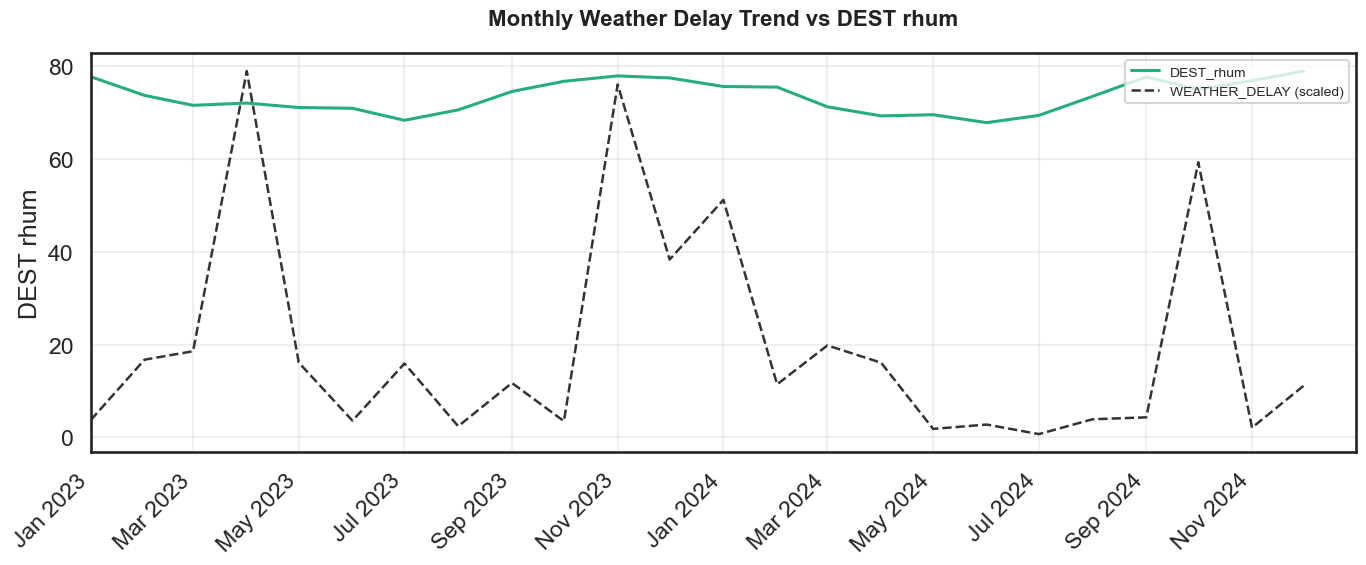

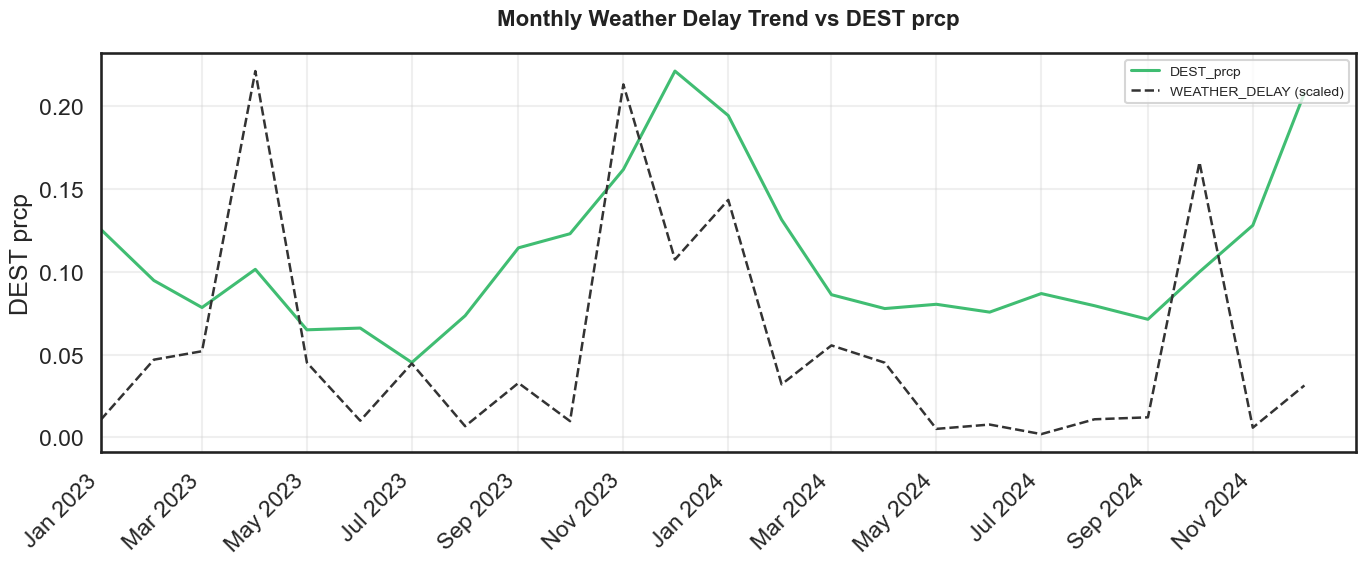

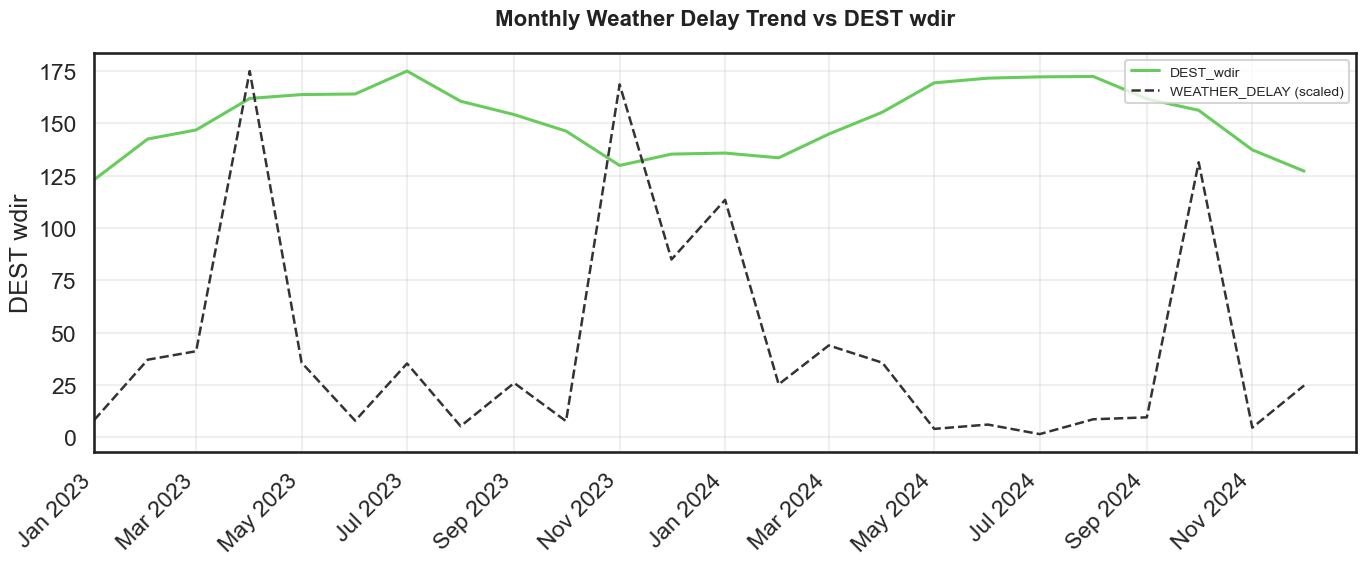

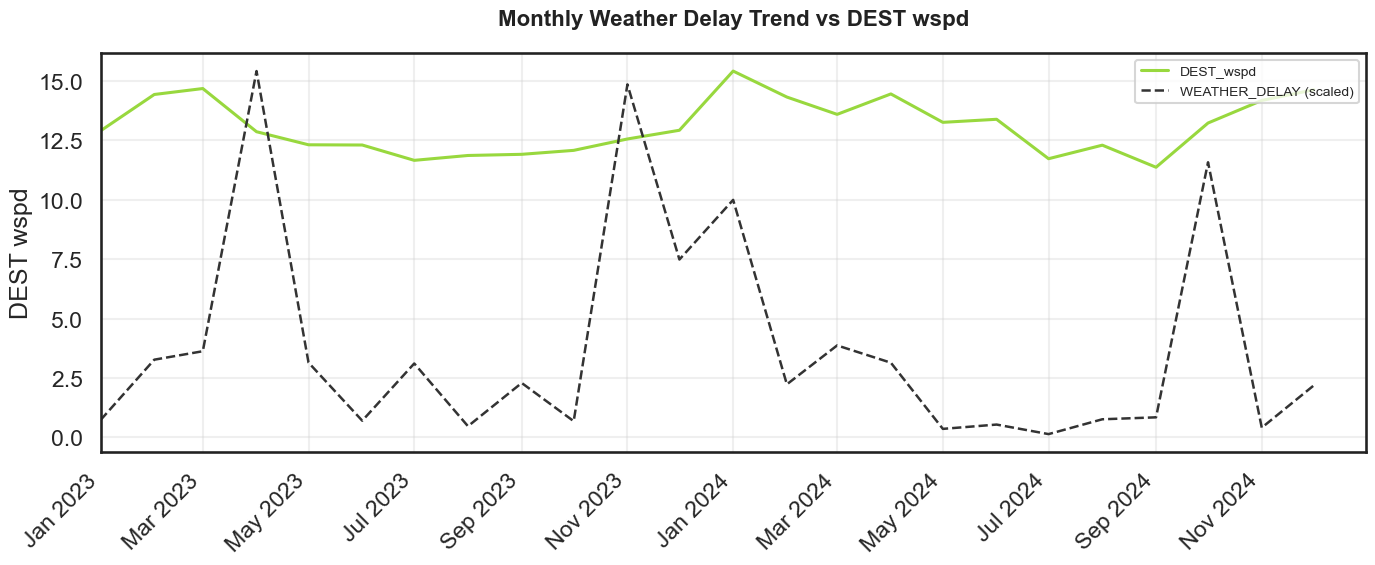

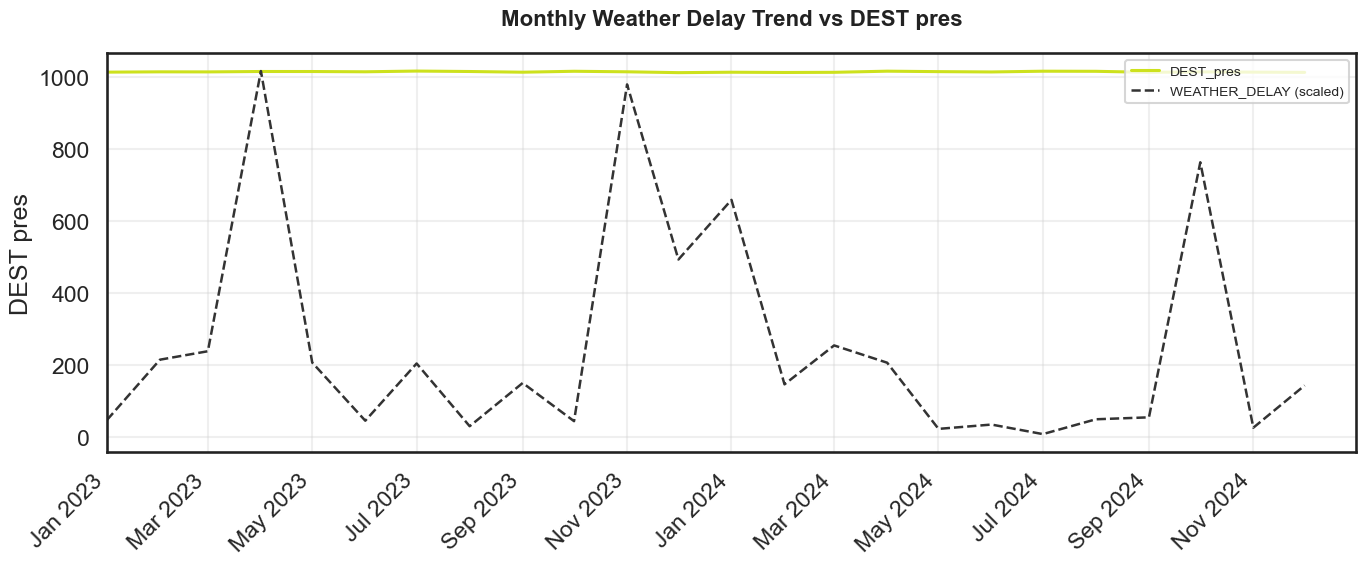

In [33]:
# -------------------------
# Monthly Weather Delay Trend (Viridis Style)
# -------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Prepare data ---
df_weather = df.copy()
df_weather['FL_DATE'] = pd.to_datetime(df_weather['FL_DATE'], errors='coerce')
df_weather = df_weather.dropna(subset=['FL_DATE']).sort_values('FL_DATE')

# --- Define weather variables ---
weather_vars = [
    'ORIGIN_temp', 'ORIGIN_rhum', 'ORIGIN_prcp', 'ORIGIN_snow',
    'ORIGIN_wdir', 'ORIGIN_wspd', 'ORIGIN_wpgt', 'ORIGIN_pres',
    'DEST_temp', 'DEST_rhum', 'DEST_prcp', 'DEST_snow',
    'DEST_wdir', 'DEST_wspd', 'DEST_wpgt', 'DEST_pres'
]
weather_vars = [c for c in weather_vars if c in df_weather.columns]

# --- Create month column ---
df_weather['MONTH_PERIOD'] = df_weather['FL_DATE'].dt.to_period('M').astype(str)

# --- Aggregate by month ---
agg_cols = weather_vars + ['WEATHER_DELAY']
monthly_avg = df_weather.groupby('MONTH_PERIOD')[agg_cols].mean().reset_index()
monthly_avg['MONTH_PERIOD'] = pd.to_datetime(monthly_avg['MONTH_PERIOD'])

# --- Force full time range (Jan 2023 → Dec 2024) ---
date_range = pd.date_range(start='2023-01-01', end='2024-12-31', freq='MS')
monthly_avg = monthly_avg.set_index('MONTH_PERIOD').reindex(date_range).reset_index()
monthly_avg.rename(columns={'index': 'MONTH_PERIOD'}, inplace=True)

# --- Plot style ---
sns.set_theme(style="whitegrid", context="talk", palette="viridis")
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.edgecolor'] = '#222222'
plt.rcParams['grid.color'] = '#cccccc'

# Get viridis color map
viridis = sns.color_palette("viridis", n_colors=len(weather_vars))

# --- Plot each variable ---
for i, var in enumerate(weather_vars):
    plt.figure(figsize=(14, 6))

    # Weather variable line (Viridis color)
    sns.lineplot(
        data=monthly_avg,
        x='MONTH_PERIOD', y=var,
        color=viridis[i % len(viridis)],
        linewidth=2.2,
        label=var
    )

    # Overlay scaled weather delay (black dashed)
    if 'WEATHER_DELAY' in monthly_avg.columns:
        scaled_delay = (
            monthly_avg['WEATHER_DELAY'] /
            monthly_avg['WEATHER_DELAY'].max()
        ) * monthly_avg[var].max()
        plt.plot(
            monthly_avg['MONTH_PERIOD'], scaled_delay,
            color='#333333', linestyle='--', linewidth=1.8,
            label='WEATHER_DELAY (scaled)'
        )

    # --- Axis formatting ---
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.xticks(rotation=45, ha='right')
    plt.xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2024-12-31'))
    plt.xlabel('')
    plt.ylabel(var.replace('_', ' '))
    plt.title(f'Monthly Weather Delay Trend vs {var.replace("_", " ")}', pad=20, color='#222222')
    plt.legend(fontsize=10, loc='upper right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## Part 4 - using random forest to make predictions

In [34]:
# Drop irrelevant or empty columns
drop_cols = [
    'FL_DATE', 'DEP_DATETIME', 'ARR_DATETIME',
    'ORIGIN_snow', 'DEST_snow', 'ORIGIN_wpgt', 'DEST_wpgt', 'CANCELLATION_CODE',
    'AIR_TIME',
    'CARRIER_DELAY',
    'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'TOTAL_DELAY'
]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

In [35]:
df.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CANCELLED', 'DIVERTED', 'DISTANCE',
       'CRITICAL_DELAY', 'ORIGIN_temp', 'ORIGIN_rhum', 'ORIGIN_prcp',
       'ORIGIN_wdir', 'ORIGIN_wspd', 'ORIGIN_pres', 'DEST_temp', 'DEST_rhum',
       'DEST_prcp', 'DEST_wdir', 'DEST_wspd', 'DEST_pres'],
      dtype='object')

In [36]:
# ============================================================
# Clean and Prepare Data
# ============================================================
# Fill missing values safely
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Encode categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# Folder to save models
os.makedirs("trained_models", exist_ok=True)

# ============================================================
# Define Targets and Hyperparameter Grid
# ============================================================
targets = ['DIVERTED', 'CANCELLED', 'CRITICAL_DELAY']
results = []

param_dist = {
    'n_estimators': [100, 150, 200, 300],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# ============================================================
# Train or Load Each Target Model
# ============================================================
for target in targets:
    print(f"\nProcessing target: {target}")
    model_path = f"trained_models/rf_best_{target}.joblib"
    start = time.time()

    # Prepare data
    X = df.drop(columns=targets)
    y = df[target].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    counts_before = y_train.value_counts(normalize=True).to_dict()

    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    counts_after = y_train_res.value_counts(normalize=True).to_dict()

    # ------------------------------------------------------------
    # Load model if it already exists, else tune and save
    # ------------------------------------------------------------
    if os.path.exists(model_path):
        best_rf = joblib.load(model_path)
        tuned = False
    else:
        base_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
        search = RandomizedSearchCV(
            estimator=base_rf,
            param_distributions=param_dist,
            n_iter=20,
            scoring='f1',
            cv=3,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
        search.fit(X_train_res, y_train_res)
        best_rf = search.best_estimator_

        joblib.dump(best_rf, model_path)
        tuned = True

    # ------------------------------------------------------------
    # Evaluate model performance
    # ------------------------------------------------------------
    y_pred = best_rf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    duration = round(time.time() - start, 1)

    results.append({
        "Target": target,
        "Before Balance": counts_before,
        "After Balance": counts_after,
        "Accuracy": round(report["accuracy"], 3),
        "Precision": round(report["1"]["precision"], 3),
        "Recall": round(report["1"]["recall"], 3),
        "F1": round(report["1"]["f1-score"], 3),
        "Time (s)": duration
    })

# ============================================================
# Display Summary
# ============================================================
summary_table = pd.DataFrame(results)

print("\n")
print(tabulate(summary_table, headers="keys", tablefmt="github", showindex=False))



Processing target: DIVERTED

Processing target: CANCELLED

Processing target: CRITICAL_DELAY


| Target         | Before Balance                                   | After Balance    |   Accuracy |   Precision |   Recall |    F1 |   Time (s) |
|----------------|--------------------------------------------------|------------------|------------|-------------|----------|-------|------------|
| DIVERTED       | {0: 0.9971834856082984, 1: 0.002816514391701587} | {0: 0.5, 1: 0.5} |      0.996 |       0     |    0     | 0     |        0.4 |
| CANCELLED      | {0: 0.9868448169265646, 1: 0.01315518307343546}  | {0: 0.5, 1: 0.5} |      0.982 |       0.211 |    0.125 | 0.157 |        0.3 |
| CRITICAL_DELAY | {0: 0.9436353644294841, 1: 0.0563646355705159}   | {1: 0.5, 0: 0.5} |      0.932 |       0.247 |    0.098 | 0.14  |        0.3 |



 Feature importances for: DIVERTED
          Feature  Importance
             DEST    0.135615
         DISTANCE    0.077829
      ORIGIN_wspd    0.070625
     CRS_DEP_TIME    0.058736
        DEST_temp    0.057680
OP_CARRIER_FL_NUM    0.055496
         TAIL_NUM    0.050903
     CRS_ARR_TIME    0.049370
      ORIGIN_wdir    0.046530
      ORIGIN_rhum    0.045111
        DEST_wdir    0.035495
        DEST_pres    0.033201
      ORIGIN_temp    0.032607
        DEST_rhum    0.032459
      DAY_OF_WEEK    0.031546


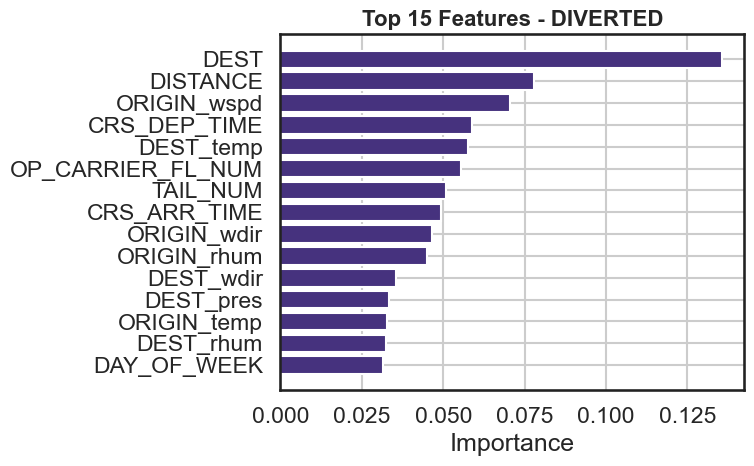


 Feature importances for: CANCELLED
          Feature  Importance
         TAIL_NUM    0.083357
        DEST_wspd    0.070066
          QUARTER    0.069512
            MONTH    0.064825
        DEST_prcp    0.048858
      ORIGIN_rhum    0.048169
        DEST_wdir    0.047188
     DAY_OF_MONTH    0.046360
        DEST_temp    0.042318
      ORIGIN_wspd    0.042223
      DAY_OF_WEEK    0.041695
         DISTANCE    0.041300
     CRS_ARR_TIME    0.039686
OP_CARRIER_FL_NUM    0.039595
      ORIGIN_temp    0.039101


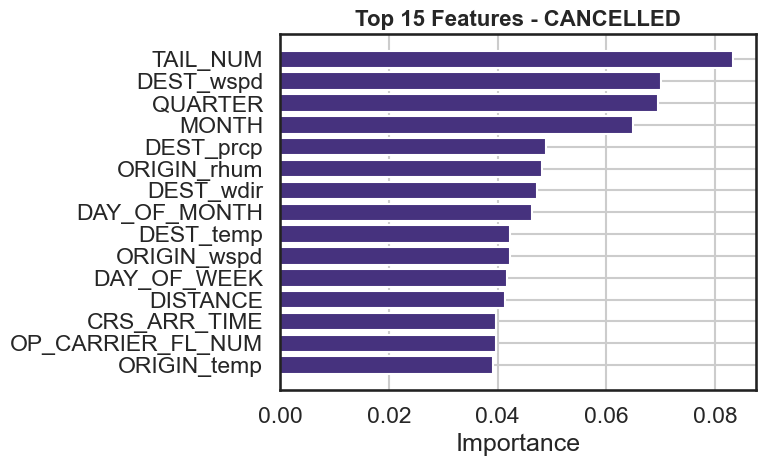


 Feature importances for: CRITICAL_DELAY
     Feature  Importance
 ORIGIN_wspd    0.111506
   DEST_wspd    0.058814
 ORIGIN_temp    0.056882
 ORIGIN_wdir    0.051987
       MONTH    0.051210
 ORIGIN_rhum    0.051081
 DAY_OF_WEEK    0.047229
     QUARTER    0.045415
DAY_OF_MONTH    0.042763
CRS_DEP_TIME    0.042176
    TAIL_NUM    0.040981
   DEST_wdir    0.040598
   DEST_prcp    0.039096
CRS_ARR_TIME    0.038752
   DEST_temp    0.034826


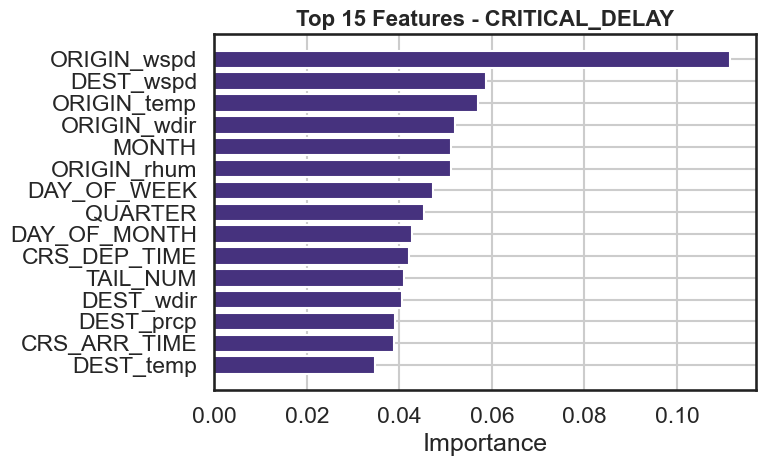

In [37]:
# Folder with saved models
model_dir = "trained_models"

# Use the same features as before (drop the targets)
feature_names = df.drop(columns=targets).columns

# Loop through each trained model
for target in targets:
    model_path = f"{model_dir}/rf_best_{target}.joblib"
    print(f"\n Feature importances for: {target}")

    # Load model
    rf = joblib.load(model_path)

    # Extract feature importances
    importances = rf.feature_importances_
    importance_df = (
        pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        })
        .sort_values("Importance", ascending=False)
        .reset_index(drop=True)
    )

    # Display top 15 features as table
    print(importance_df.head(15).to_string(index=False))

    # (Optional) Bar chart visualization
    plt.figure(figsize=(8, 5))
    plt.barh(importance_df["Feature"].head(15)[::-1],
             importance_df["Importance"].head(15)[::-1])
    plt.xlabel("Importance")
    plt.title(f"Top 15 Features - {target}")
    plt.tight_layout()
    plt.show()


ValueError: x and y must have same first dimension, but have shapes (33,) and (36393,)

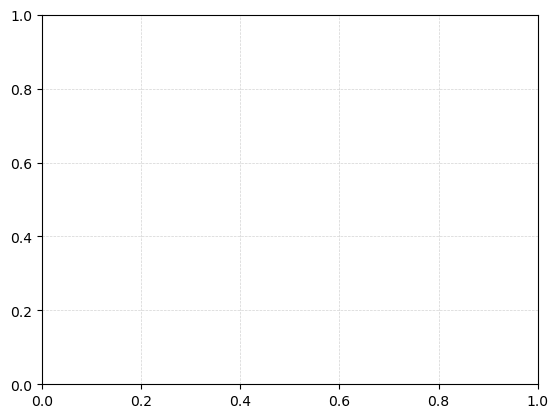

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a consistent base style
plt.style.use("default")
sns.set_palette("viridis")

# Global settings for text and gridlines
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "grid.color": "lightgray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
})

# Example: single plot
plt.figure()
plt.plot(x, y, label="Example")
plt.title("Sample Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend(loc="best")
plt.show()

# Example: subplot layout
fig, axes = plt.subplots(2, 2)
for ax in axes.flat:
    ax.plot(x, y, color=sns.color_palette("viridis")[0])
    ax.set_title("Subplot Title", fontsize=14)
    ax.set_xlabel("X-axis", fontsize=12)
    ax.set_ylabel("Y-axis", fontsize=12)
    ax.grid(True, color="lightgray", linestyle="--", linewidth=0.5)
fig.tight_layout()
plt.show()
